# QSAR Oral Toxicity Dataset - Lab 7

In [1]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from imblearn.over_sampling import SMOTE
from subprocess import call
from scipy.spatial.distance import pdist, squareform

In [2]:
data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
target = 'IS_TOXIC'
original_data = data.copy()
data_unbalanced = data.copy()
y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels = pd.unique(y)

#### \[No Normalization Needed]

### Balancing

In [3]:
def balancing(trnX, trnY, undersample, oversample):
    #undersample, oversample = 1,0 => undersample
    #undersample, oversample = 0,1 => oversample
    unique, counts = np.unique(trnY, return_counts=True)
    
    min_positive_counts = min(counts)
    min_negative_counts = max(counts)+(min(counts)-max(counts))*undersample
    newtrnY: np.ndarray = []
    newtrnX: np.ndarray = []
    for idx in range(len(trnY)):
        if min_positive_counts > 0 and trnY[idx] == 1:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_positive_counts -= 1
        elif min_negative_counts > 0 and trnY[idx] == 0:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_negative_counts -= 1
            
    unique1, counts1 = np.unique(newtrnY, return_counts=True)
    
    max_positive_counts = min(counts1)+(max(counts1)-min(counts1))*oversample
    max_negative_counts = max(counts1)
    finaltrnY: np.ndarray = []
    finaltrnX: np.ndarray = []
    negX: np.ndarray = []
    posX: np.ndarray = []
    negY: np.ndarray = []
    posY: np.ndarray = []
        
    for idx in range(len(newtrnY)):
        if newtrnY[idx] == 0:
            finaltrnY.append(newtrnY[idx])
            negY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            negX.append(newtrnX[idx])
            max_negative_counts -= 1
        elif newtrnY[idx] == 1:
            finaltrnY.append(newtrnY[idx])
            posY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            posX.append(newtrnX[idx])
            max_positive_counts -= 1

    random.seed()

    while max_negative_counts > 0:
        rand_num = random.randint(0,len(negX)-1)
        finaltrnX.append(negX[rand_num])
        finaltrnY.append(negY[rand_num])
        max_negative_counts -= 1

    while max_positive_counts > 0:
        rand_num = random.randint(0,len(posX)-1)
        finaltrnX.append(posX[rand_num])
        finaltrnY.append(posY[rand_num])
        max_positive_counts -= 1
    
    return finaltrnX, finaltrnY

In [4]:
def balancing_v1(data_frame):
    data_frame_to_modify = data_frame.copy()
    target_count = data_frame_to_modify[target].value_counts()
    min_class = target_count.idxmin()
    ind_min_class = target_count.index.get_loc(min_class)

    RANDOM_STATE = 50
    values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

    df_class_min = data_frame_to_modify[data_frame_to_modify[target] == min_class]
    df_class_max = data_frame_to_modify[data_frame_to_modify[target] != min_class]

    df_under = df_class_max.sample(len(df_class_min), random_state=RANDOM_STATE)
    values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
    df_over = df_class_min.sample(len(df_class_max), replace=True, random_state=RANDOM_STATE)
    values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    y = data_frame_to_modify.pop(target).values
    X = data_frame_to_modify.values
    smote_X, smote_y = smote.fit_sample(X, y)
    smote_target_count = pd.Series(smote_y).value_counts()
    values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

    over_sampled = pd.concat([df_over, df_class_max])
    under_sampled = pd.concat([df_under, df_class_min])
    
    return over_sampled, under_sampled

In [ ]:
over_sampled, under_sampled = balancing_v1(data_unbalanced)
under_sampled.pop(target)
print(end='')

# Clustering

**K-Means under sampled**

In [4]:
v1 = 0
v2 = 4

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

data_unbalanced.pop(target)
print(end='')

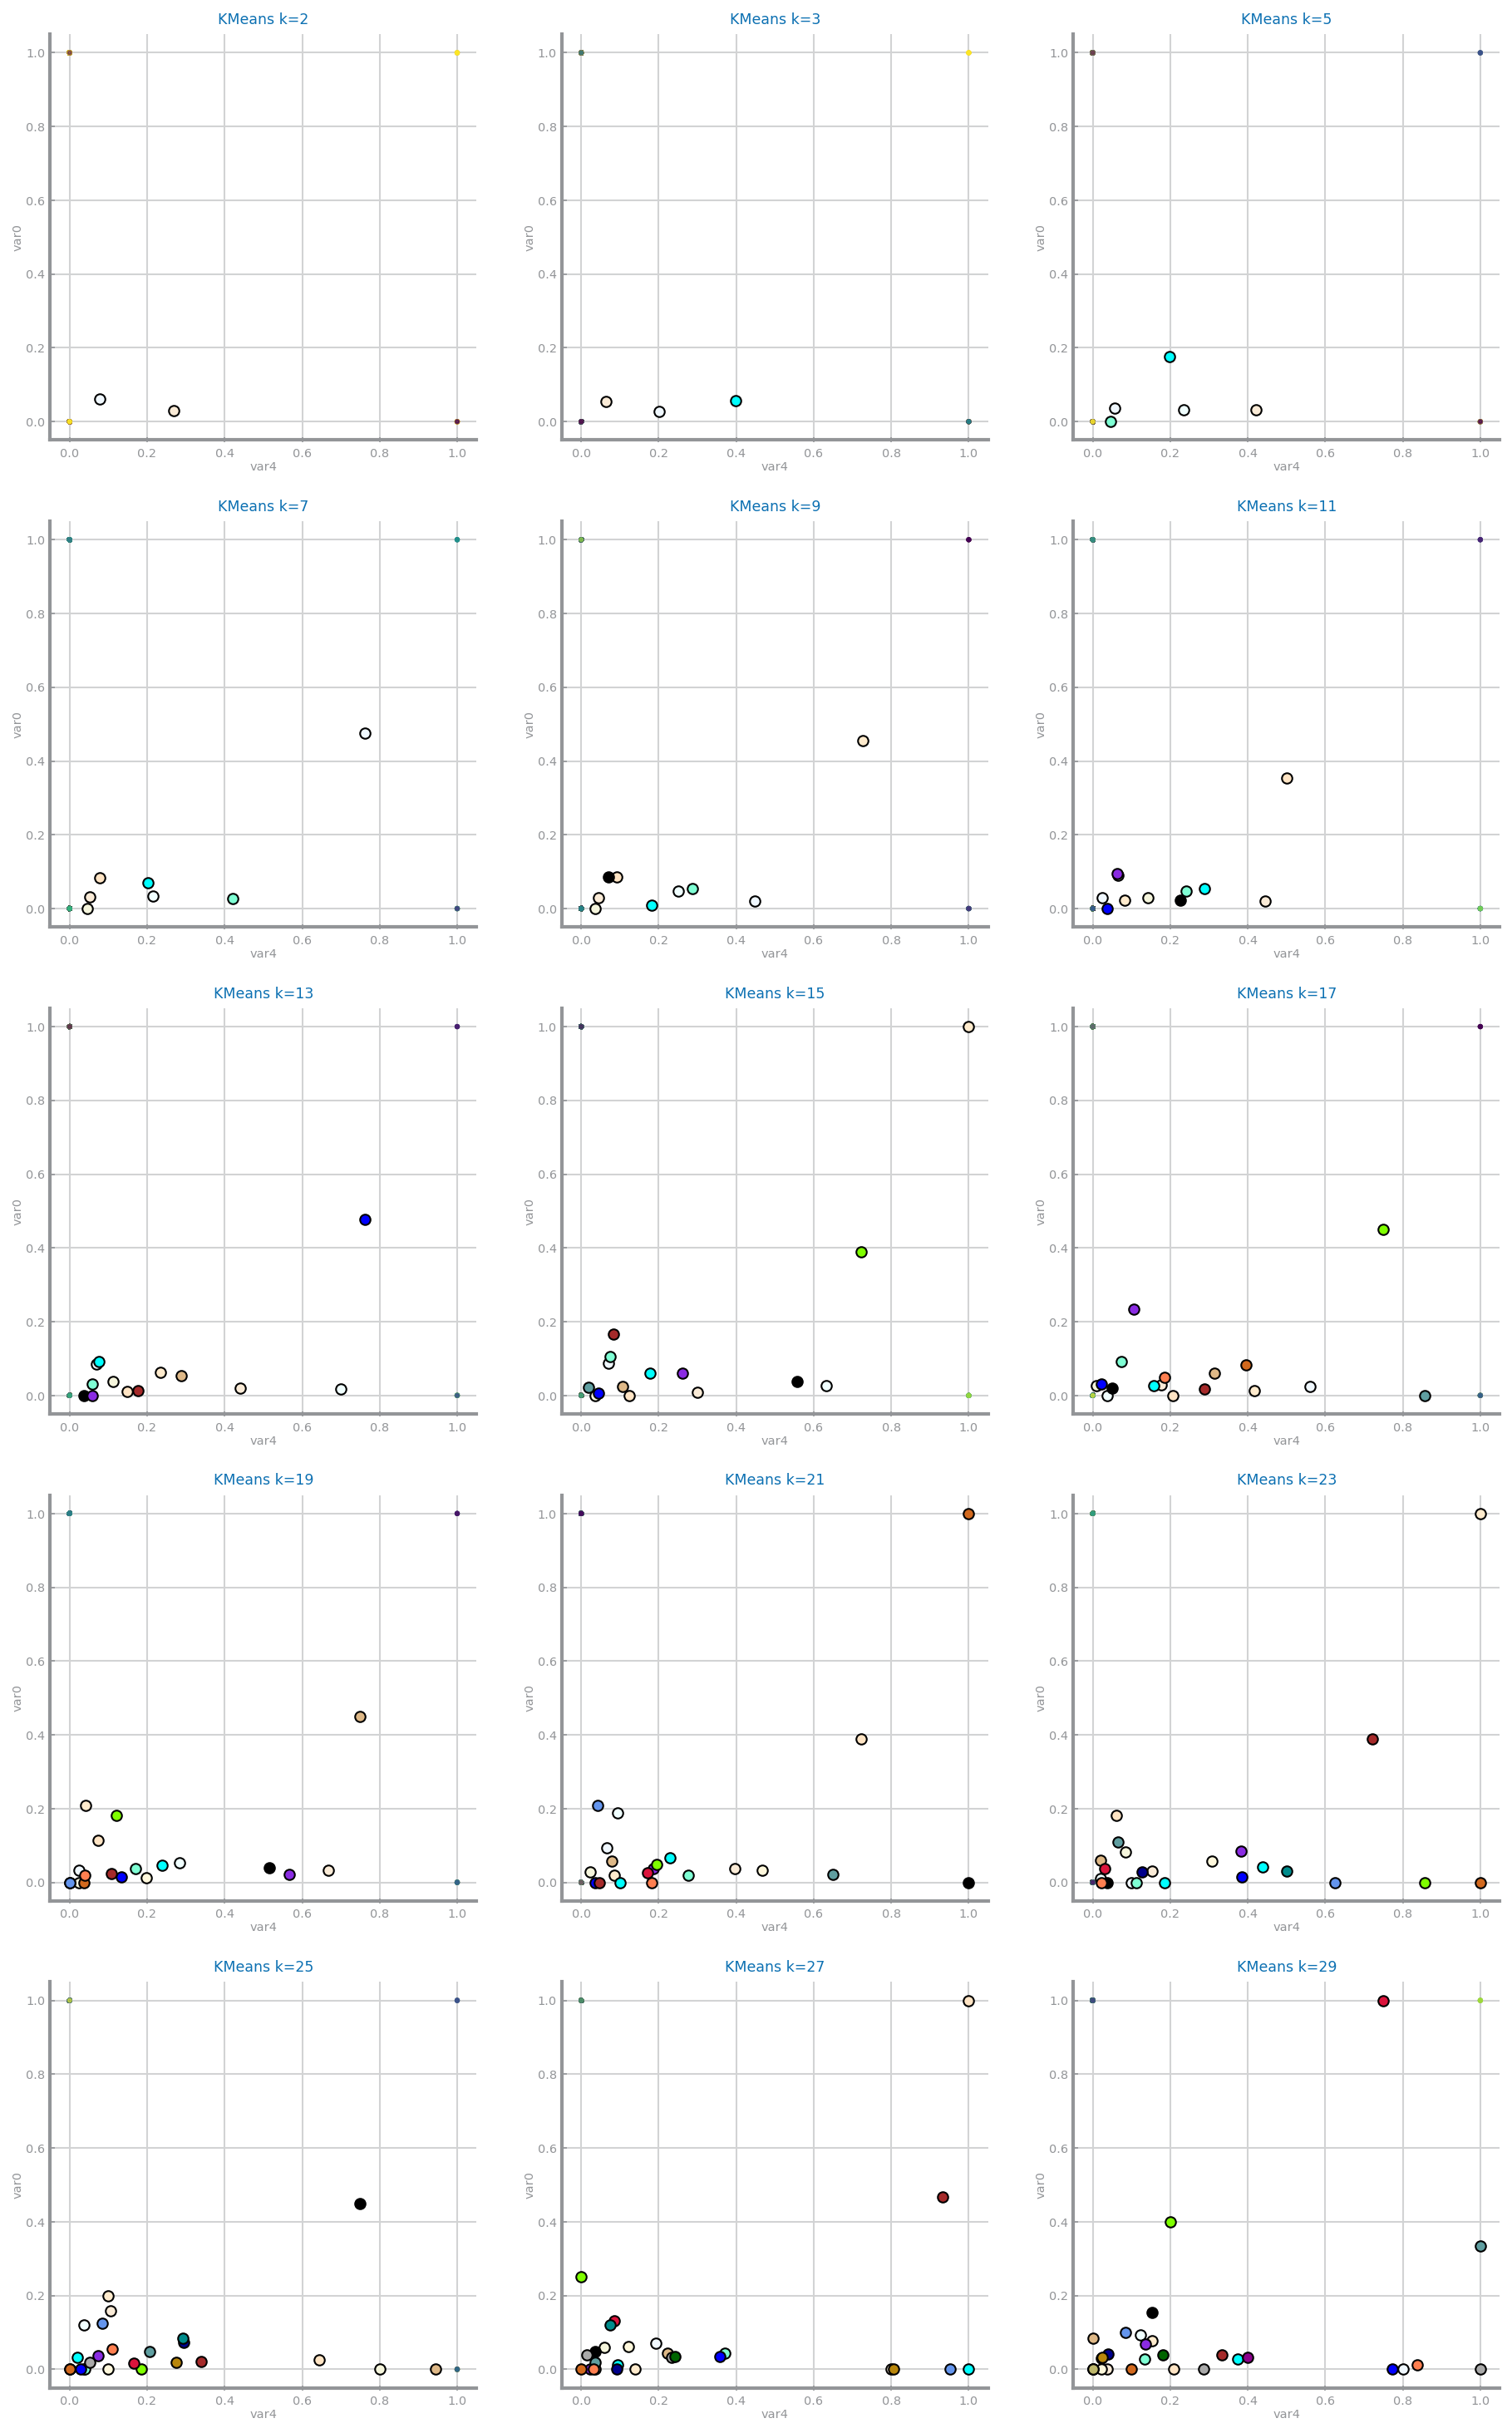

In [17]:
mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
#     estimator = KMeans(n_clusters=k,init = 'k-means++')
    estimator = KMeans(n_clusters=k)
    estimator.fit(under_sampled)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(under_sampled, estimator.labels_))
    ds.plot_clusters(under_sampled, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

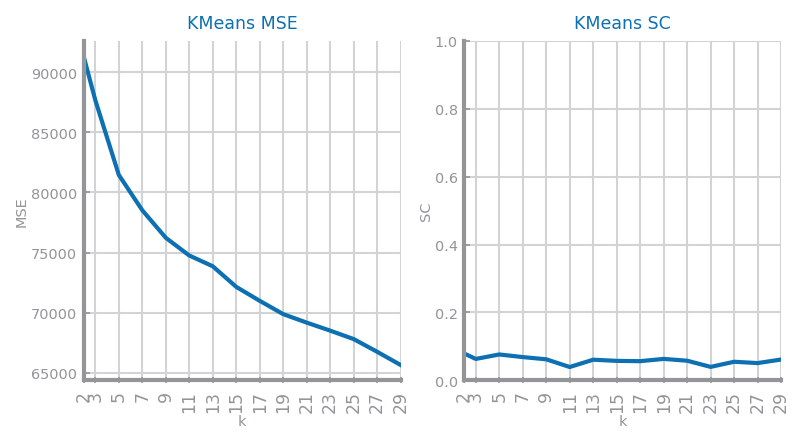

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

### Density-based

*EPS - Studying the Maximum Distance Impact*

In [9]:
def clustering_density_eps(data, eixo_x, eixo_y):
    EPS = [2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(EPS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(EPS)):
        estimator = DBSCAN(eps=EPS[n], min_samples=2)
        estimator.fit(data)
        labels = estimator.labels_
        k = len(set(labels)) - (1 if -1 in labels else 0)
        if k > 1:
            centers = ds.compute_centroids(data, labels)
            mse.append(ds.compute_mse(data.values, labels, centers))
            sc.append(silhouette_score(data, labels))
            ds.plot_clusters(data, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                             f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
            i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
        else:
            mse.append(0)
            sc.append(0)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.plot_line(EPS, mse, title='DBSCAN MSE', xlabel='eps', ylabel='MSE', ax=ax[0, 0])
    ds.plot_line(EPS, sc, title='DBSCAN SC', xlabel='eps', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

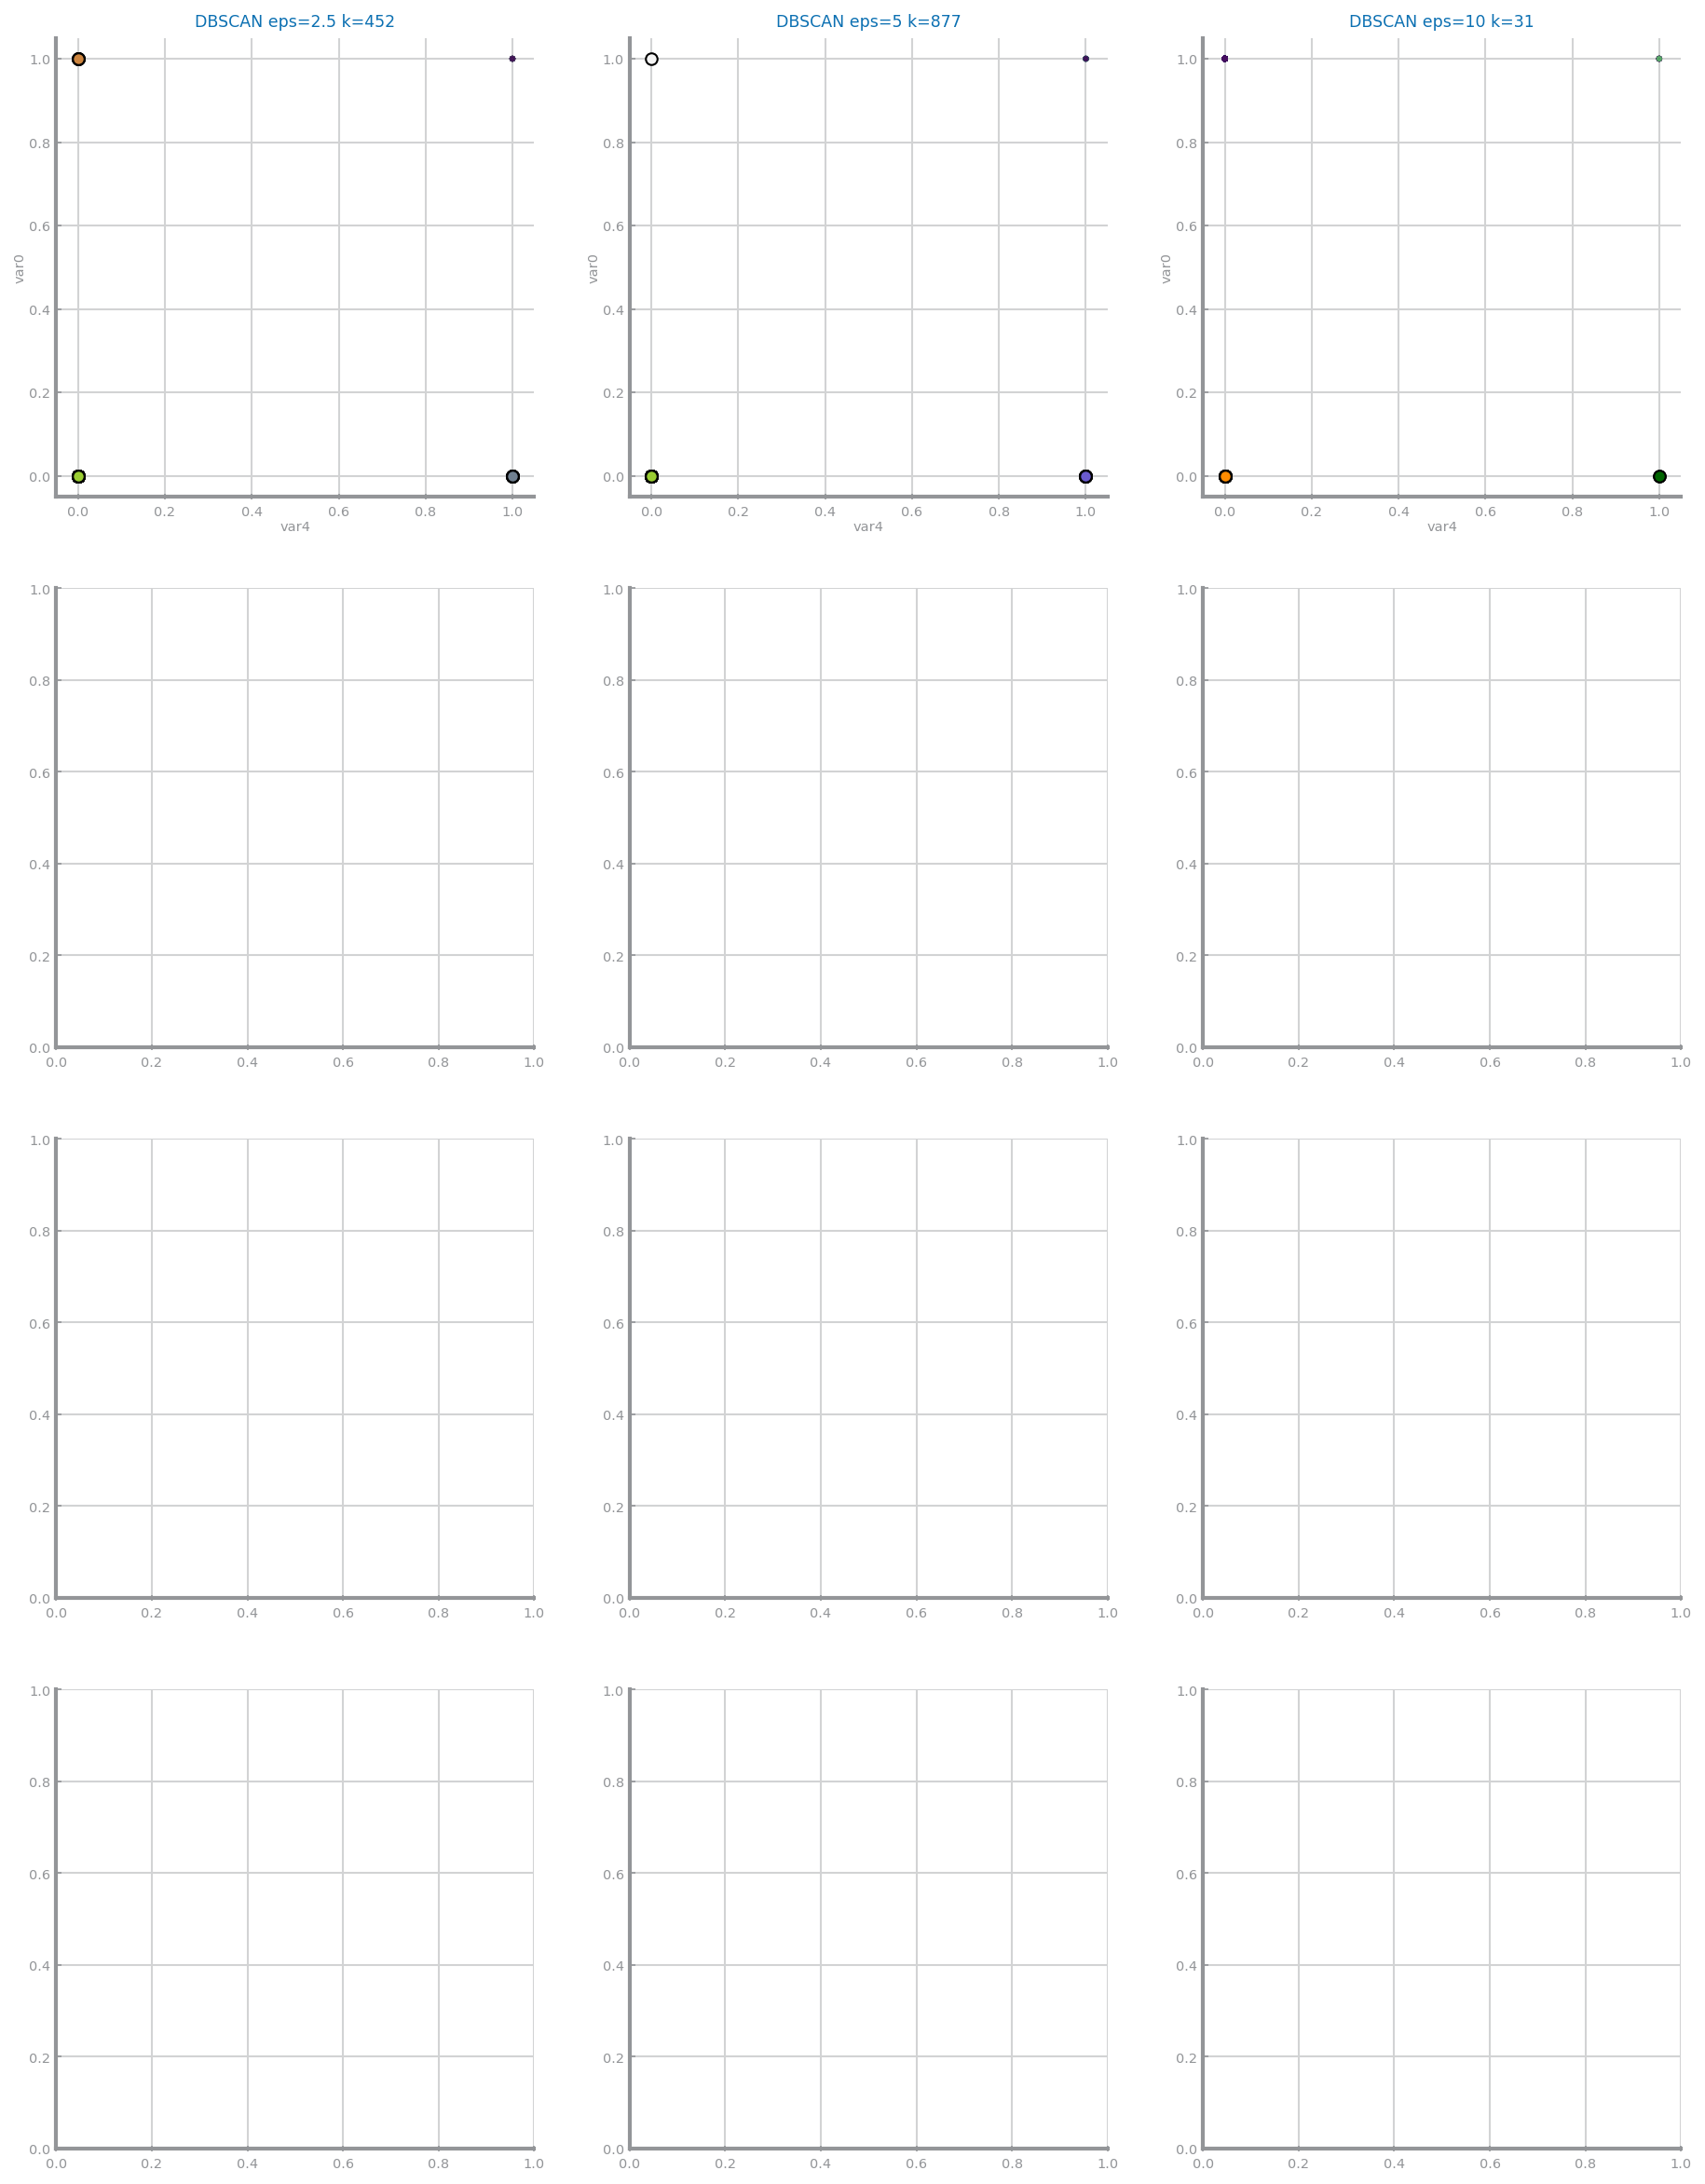

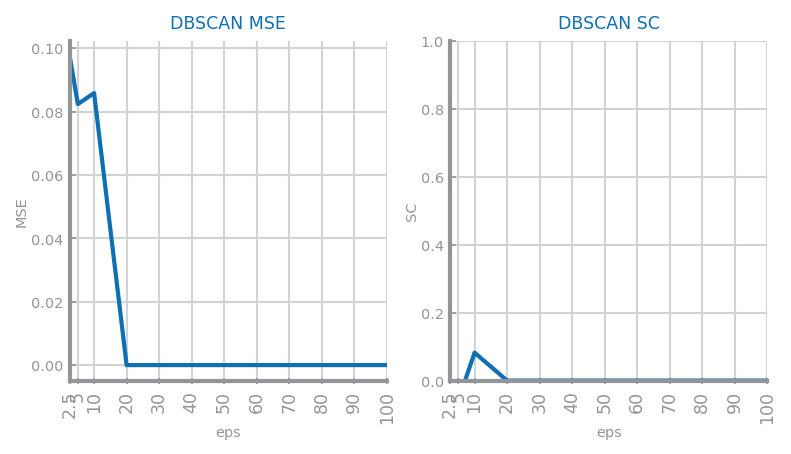

In [5]:
clustering_density_eps(data_unbalanced, v2, v1)

DBSCAN- Density-Based Spatial Clustering of Applications with Noise
Erro Quadrático Médio diminui com o Optimal Value For Epsilon
Silhouette Score não teve resultados relevantes

*Metric*

In [10]:
def clustering_density_metric(data, eixo_x, eixo_y):
    METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
    distances = []
    for m in METRICS:
        dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
        distances.append(dist)

    print('AVG distances among records', distances)
    distances[0] = 80
    distances[1] = 50
    distances[2] = 80
    distances[3] = 0.0005
    distances[4] = 0.0009
    print('CHOSEN EPS', distances)
    
    print('\n')
    
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(METRICS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(METRICS)):
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
        estimator.fit(data)
        labels = estimator.labels_
        k = len(set(labels)) - (1 if -1 in labels else 0)
        if k > 1:
            centers = ds.compute_centroids(data, labels)
            mse.append(ds.compute_mse(data.values, labels, centers))
            sc.append(silhouette_score(data, labels))
            ds.plot_clusters(data, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                             f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
        else:
            mse.append(0)
            sc.append(0)
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
    ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

AVG distances among records [11.441172559146954, 134.88438321707076, 0.9998726131412976, 0.7082288366972024, 0.8318665315949874]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]




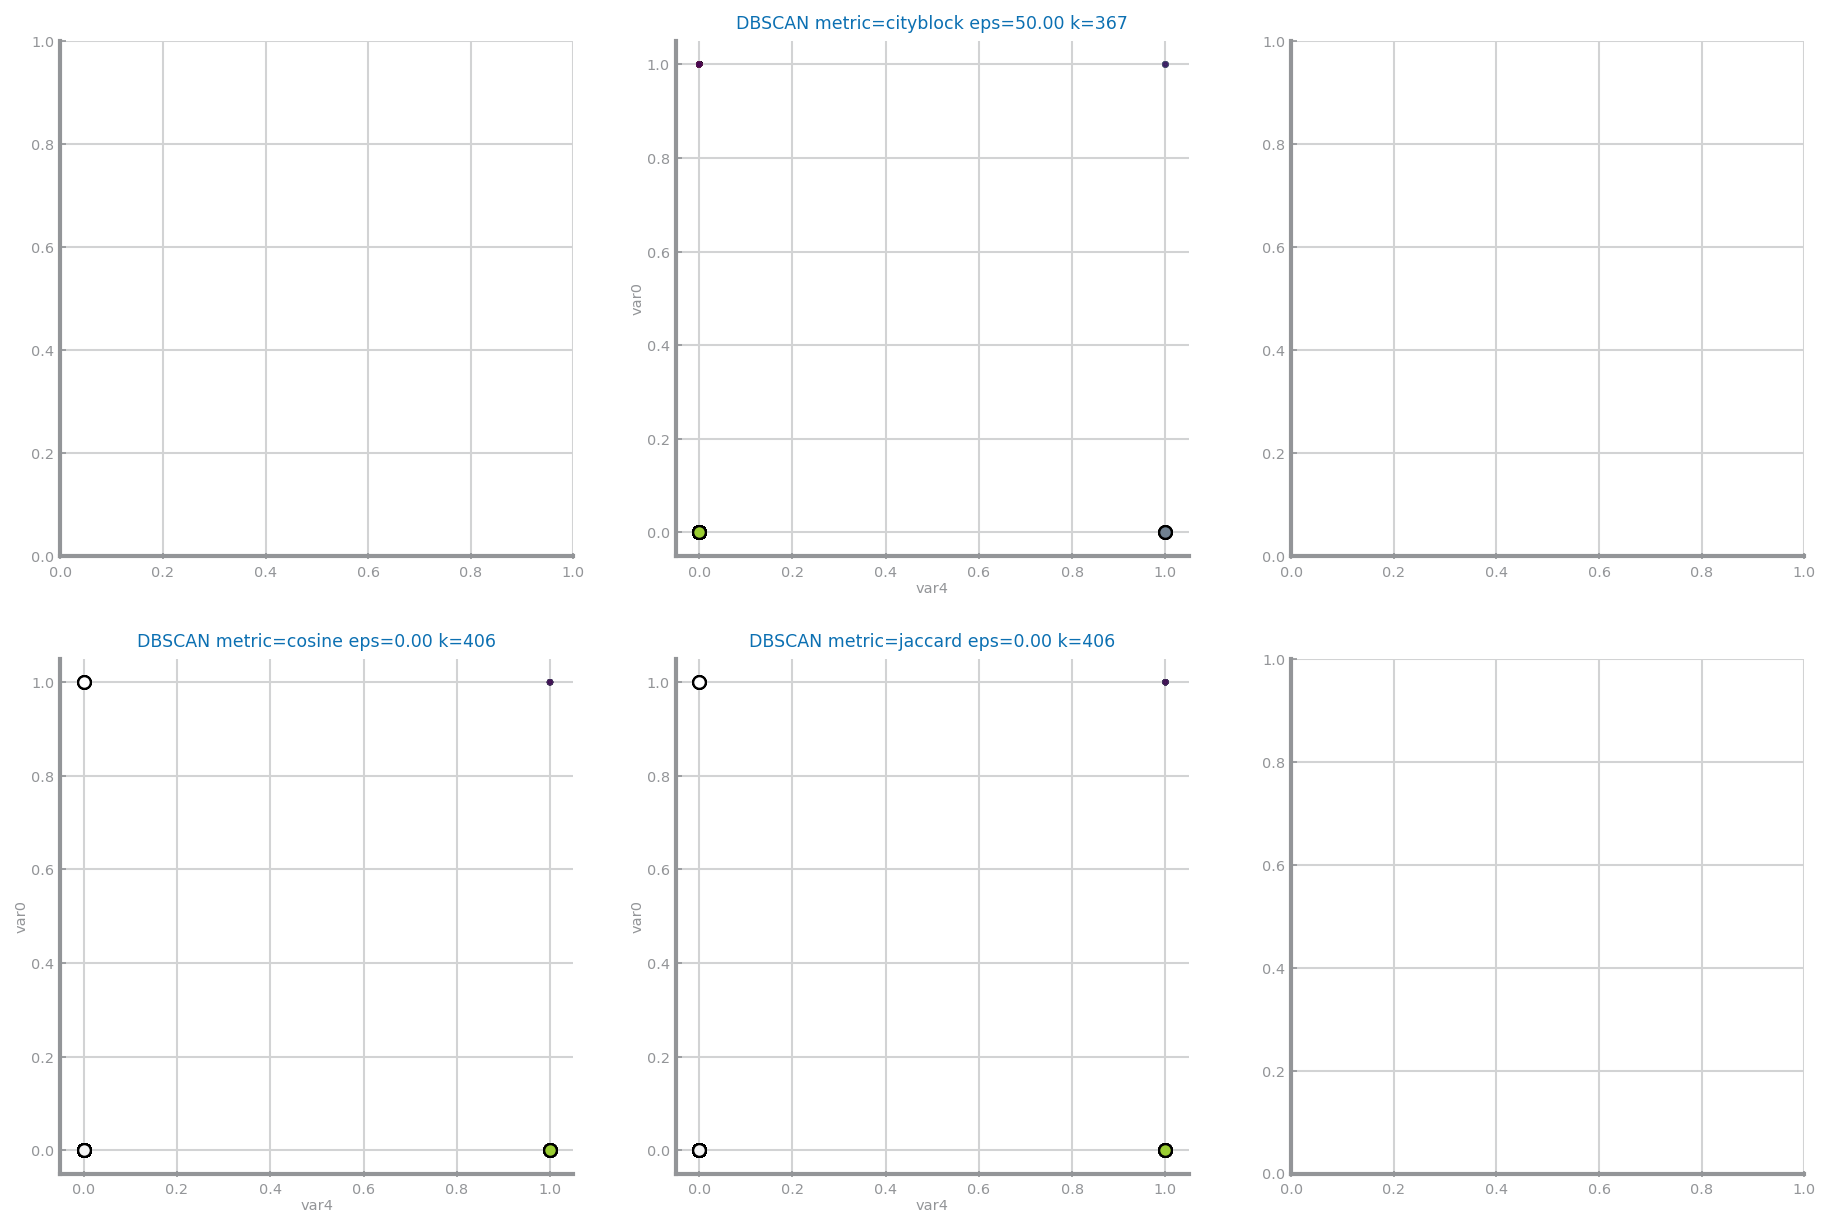

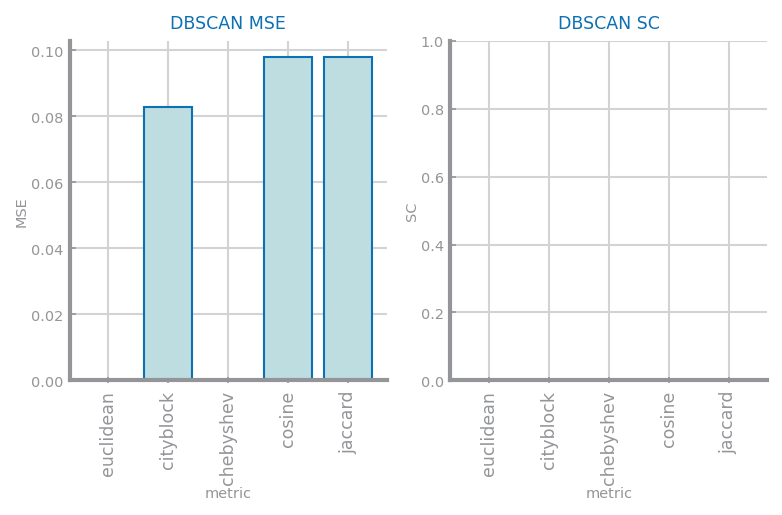

In [7]:
clustering_density_metric(data_unbalanced, v2, v1)

### Hierarchical

In [11]:
def clustering_hierarchical(data, eixo_x, eixo_y):
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(N_CLUSTERS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(N_CLUSTERS)):
        k = N_CLUSTERS[n]
        estimator = AgglomerativeClustering(n_clusters=k)
        estimator.fit(data)
        labels = estimator.labels_
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        ds.plot_clusters(data, eixo_x, eixo_y, labels, centers, k,
                         f'Hierarchical k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.plot_line(N_CLUSTERS, mse, title='Hierarchical MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
    ds.plot_line(N_CLUSTERS, sc, title='Hierarchical SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()
    
    print('\n')
    
    METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
    LINKS = ['complete', 'average']
    k = 3
    values_mse = {}
    values_sc = {}
    rows = len(METRICS)
    cols = len(LINKS)
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    for i in range(len(METRICS)):
        mse: list = []
        sc: list = []
        m = METRICS[i]
        for j in range(len(LINKS)):
            link = LINKS[j]
            estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
            estimator.fit(data)
            labels = estimator.labels_
            centers = ds.compute_centroids(data, labels)
            mse.append(ds.compute_mse(data.values, labels, centers))
            sc.append(silhouette_score(data, labels))
            ds.plot_clusters(data, eixo_x, eixo_y, labels, centers, k,
                             f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
        values_mse[m] = mse
        values_sc[m] = sc
    plt.show()
    
    print()
    
    _, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
    ds.multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

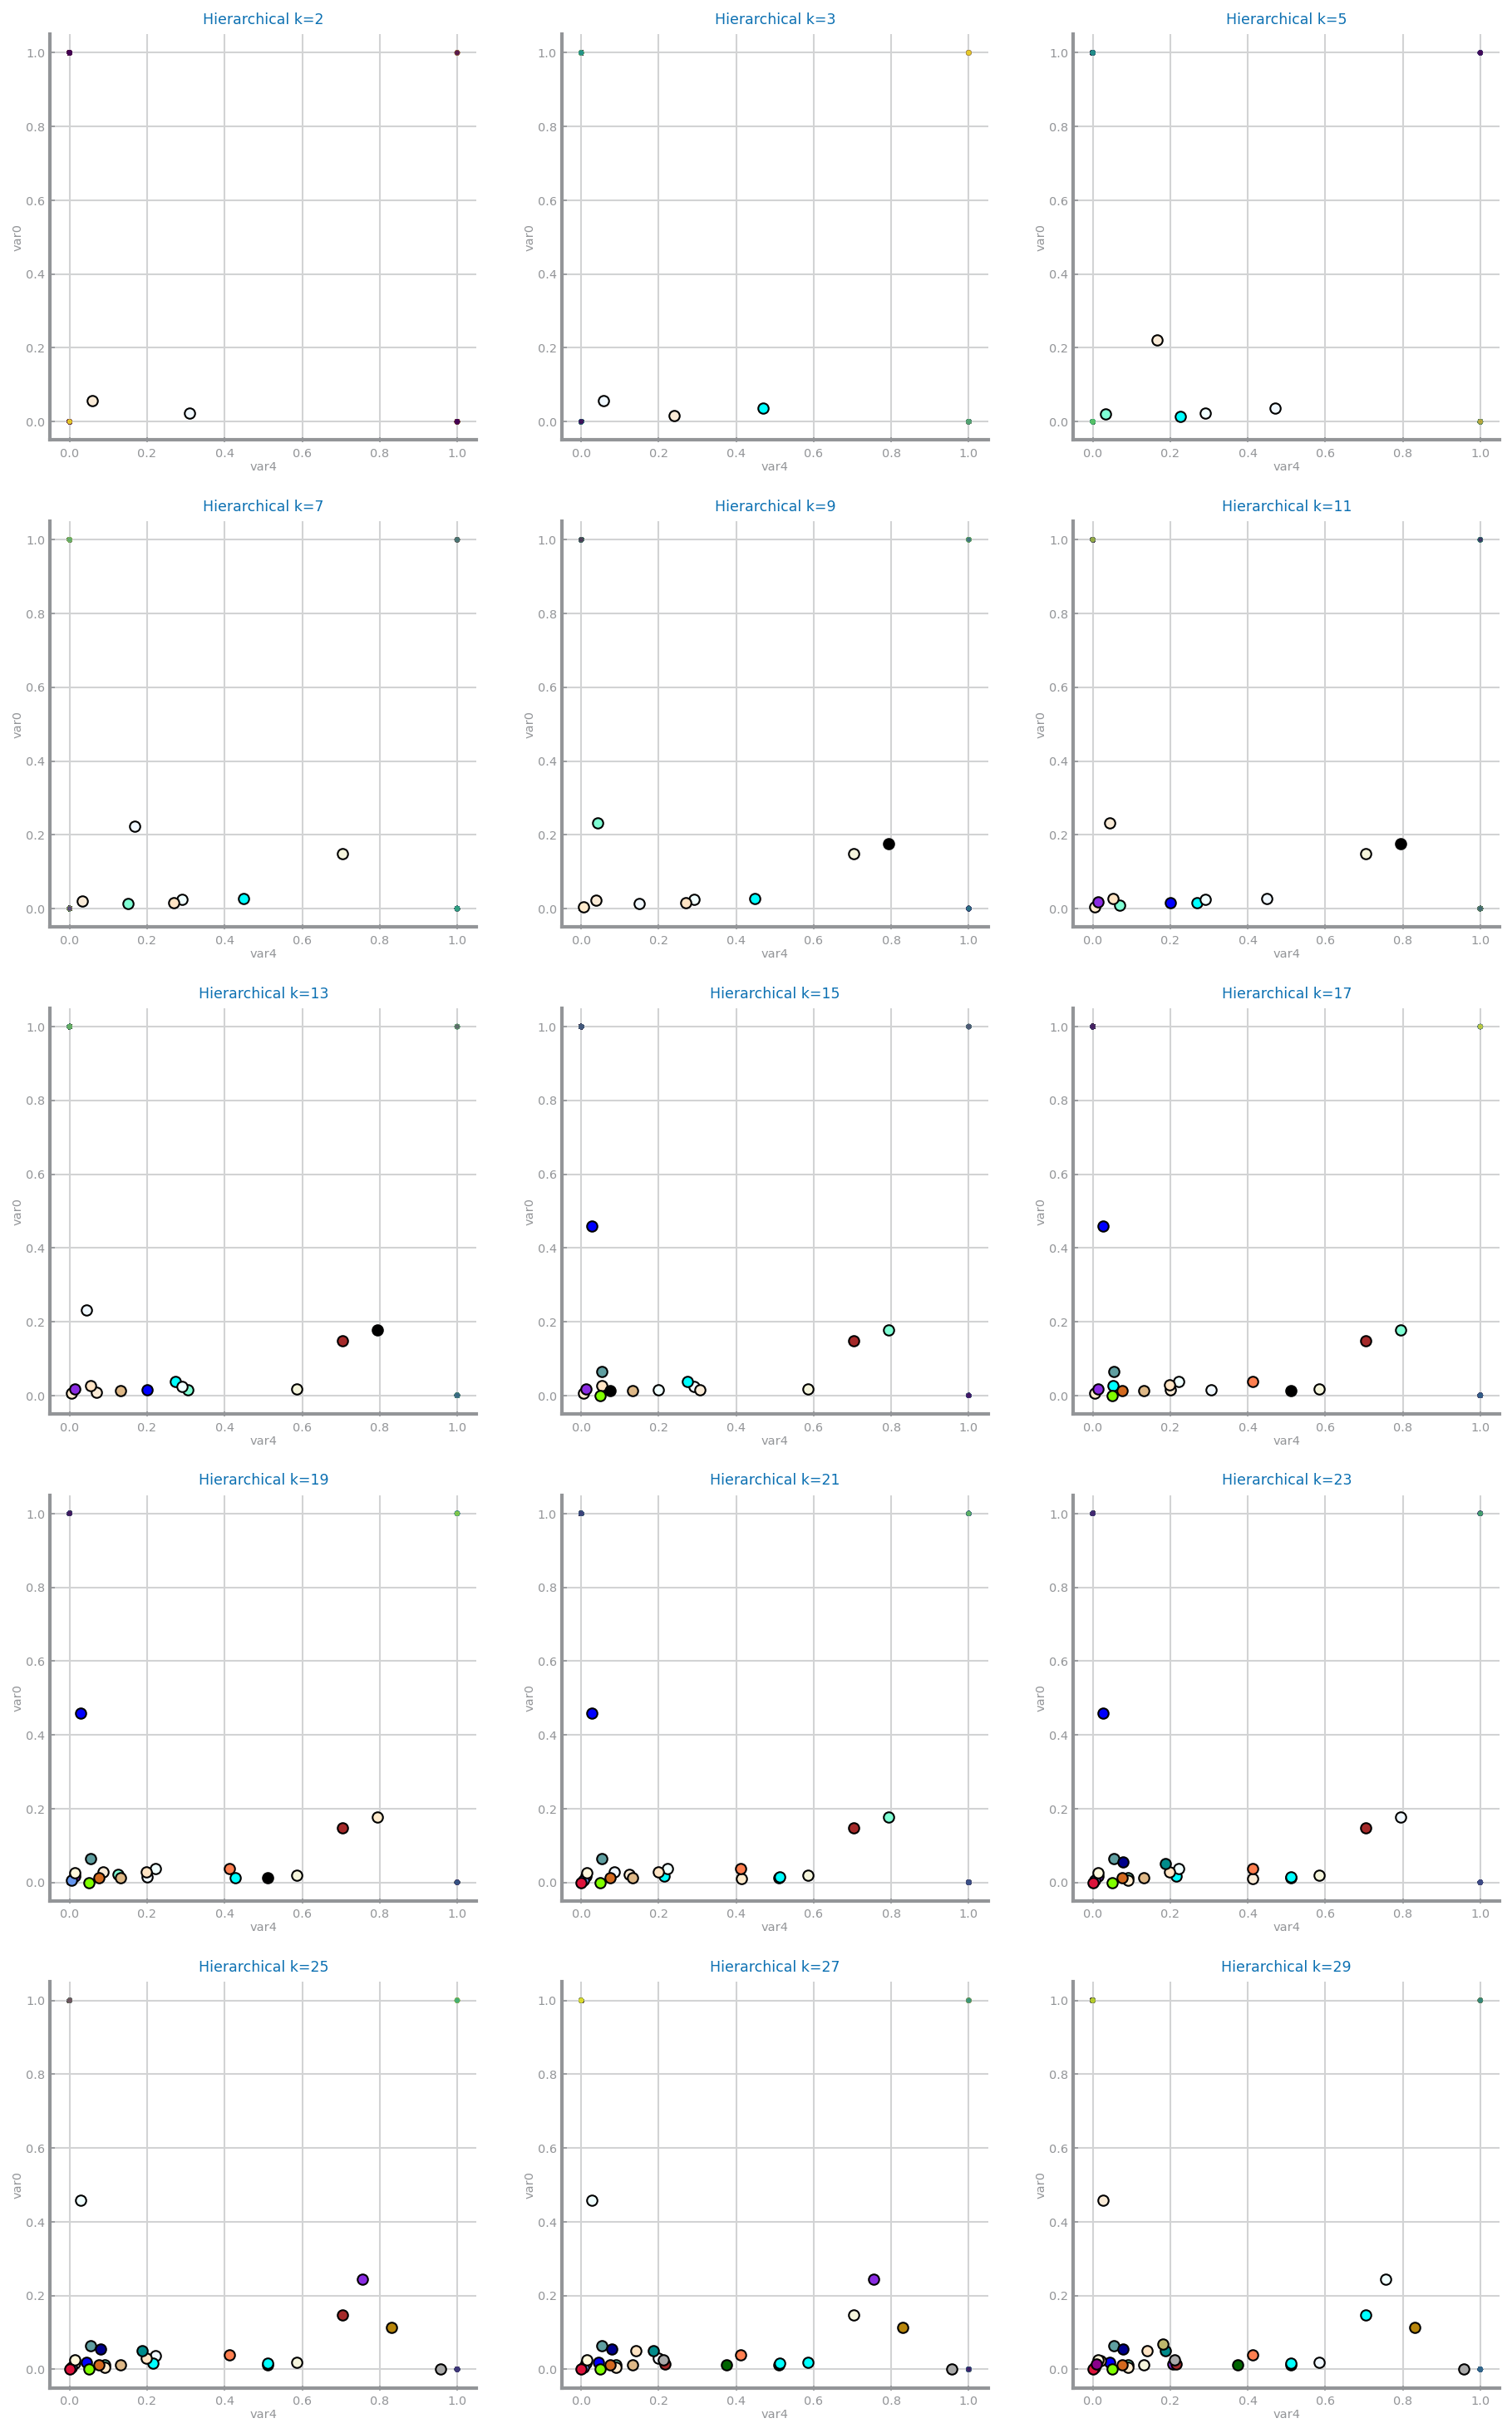

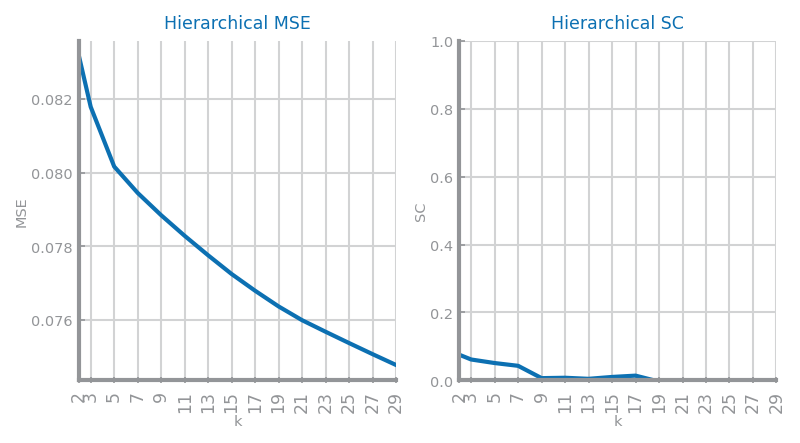

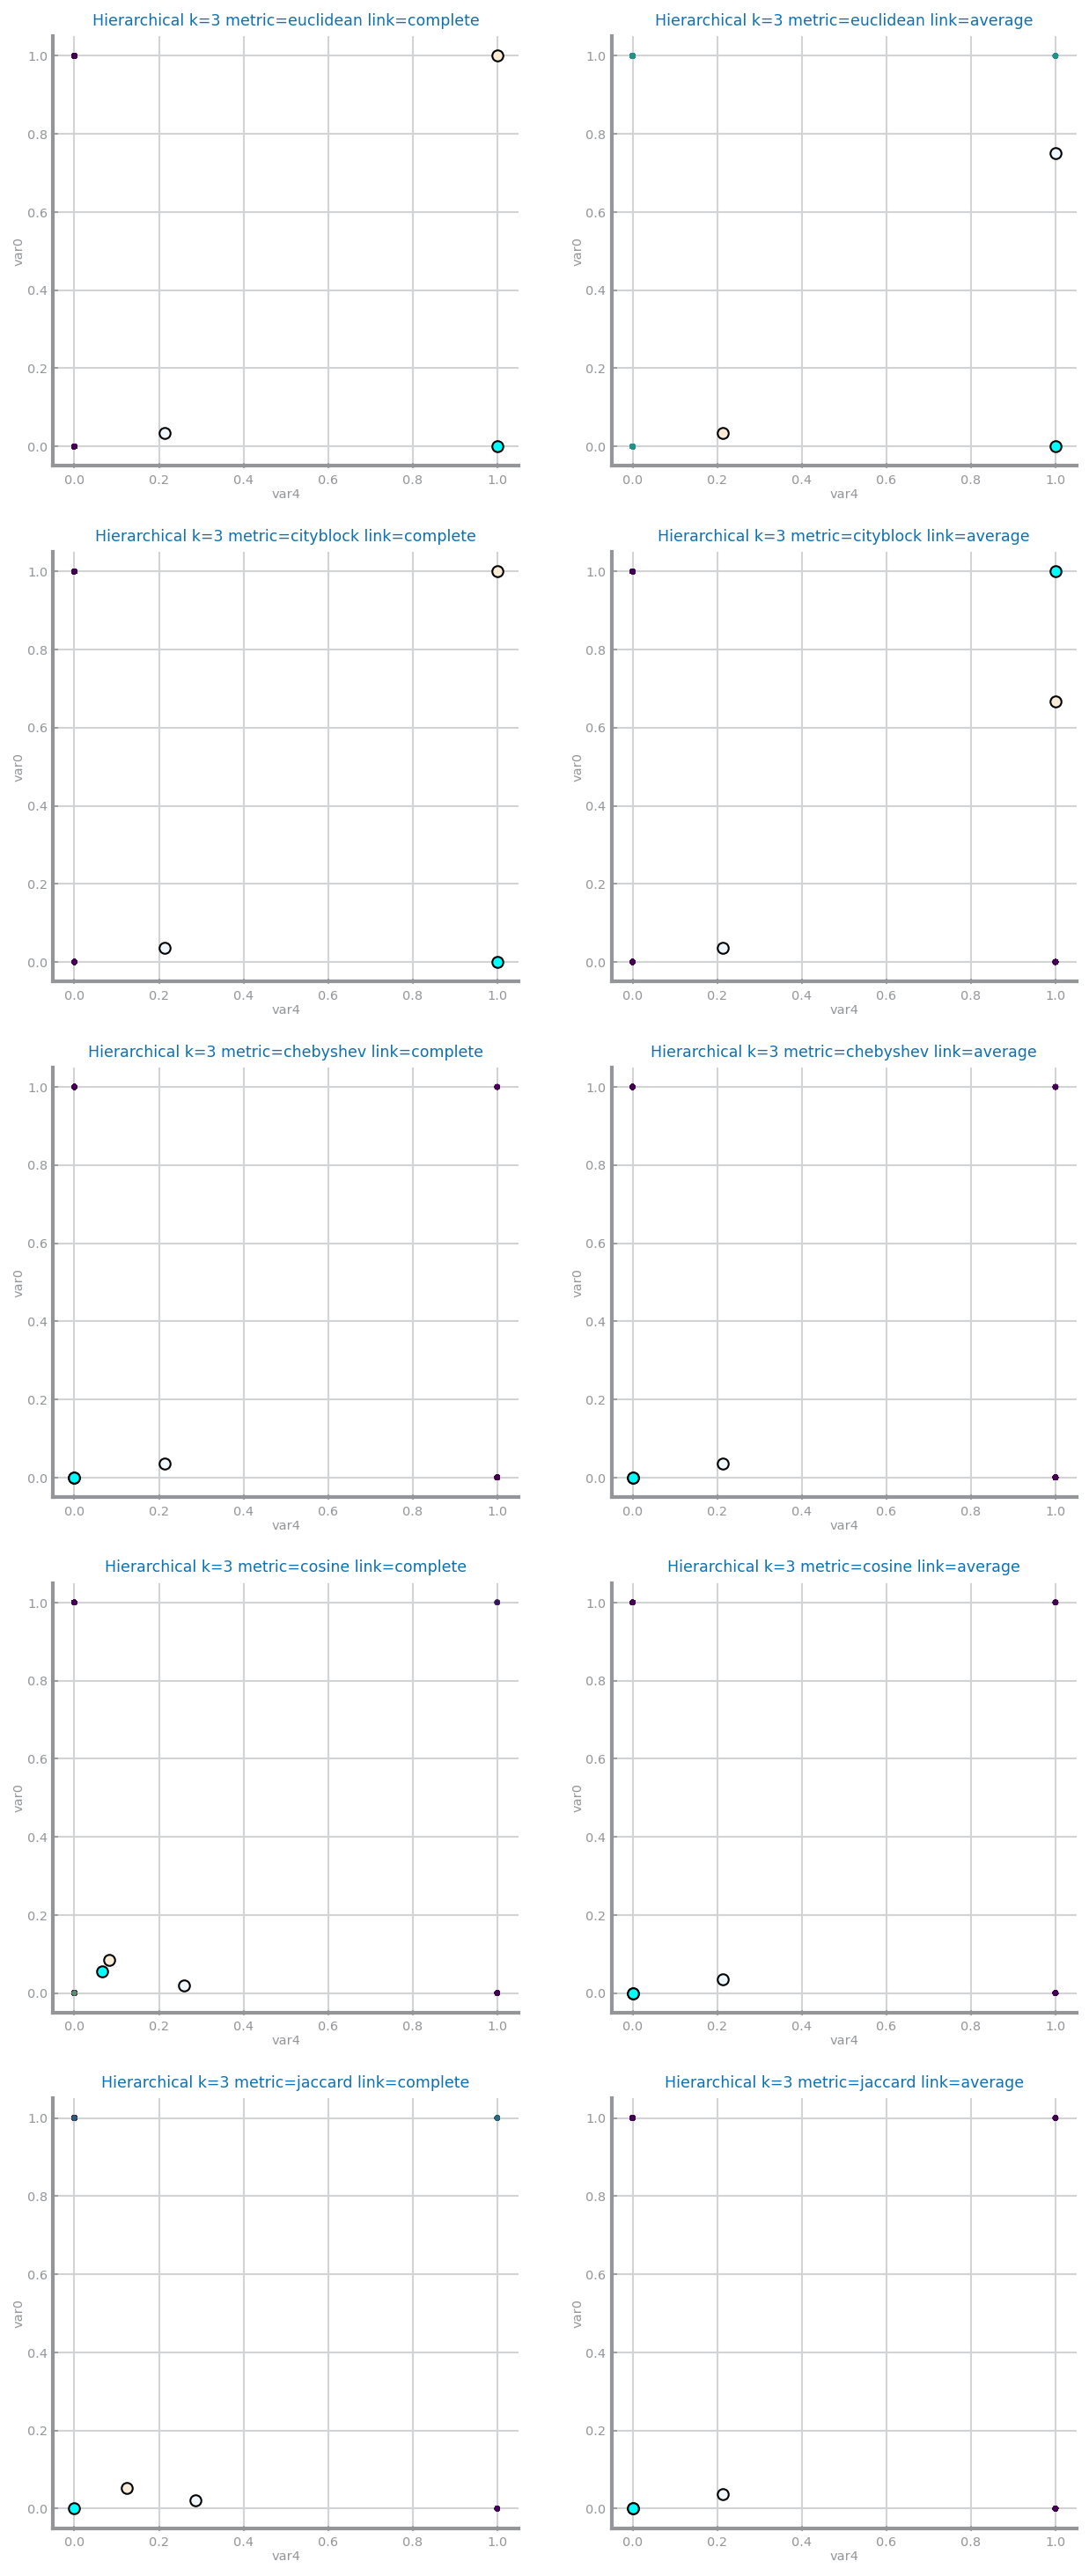

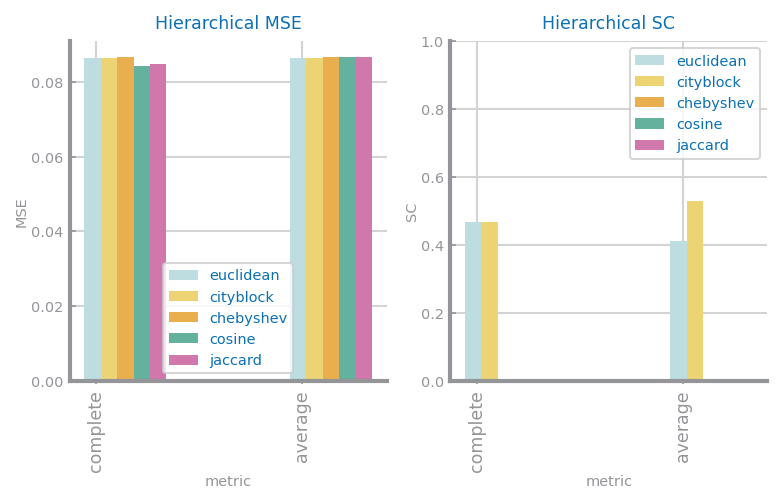

In [9]:
clustering_hierarchical(data_unbalanced, v2, v1)

Silhouette Score relevante para as métricas Euclidean e Cityblock

# Feature Extraction

## PCA

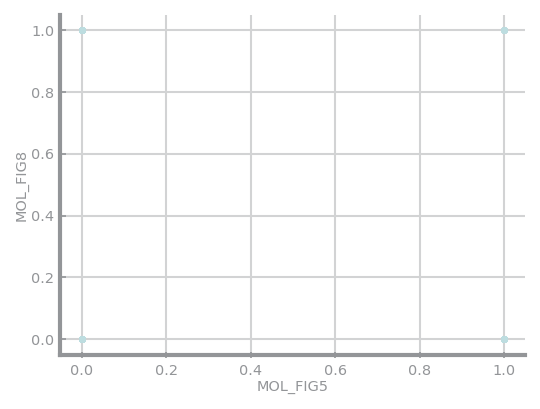

In [5]:
variables = data.columns.values
eixo_x = 0
eixo_y = 4
eixo_z = 7

plt.figure()
plt.xlabel(variables[eixo_y])
plt.ylabel(variables[eixo_z])
plt.scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])
plt.show()

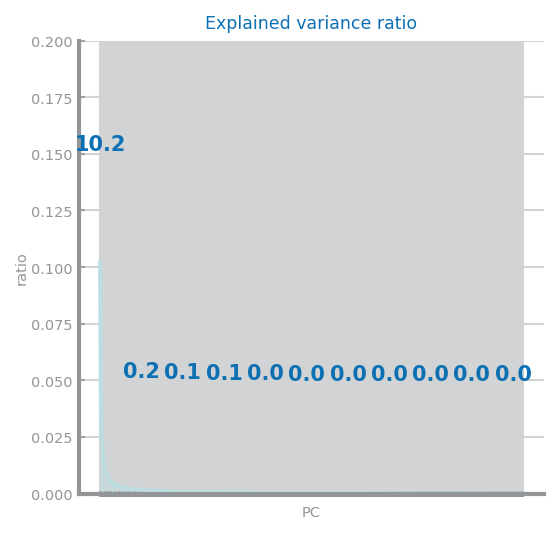

In [6]:
mean = (data.mean(axis=0)).tolist()
centered_data = data - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = np.linalg.eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# Plot Explained Variance Ration
fig = plt.figure(figsize=(4, 4))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels([])
ax.set_ylim(0.0, 0.2)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    if i%100 + 1 == 1:
        ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
plt.show()

Percentagem de variância explicada por cada um dos componentes selecionados decresce exponencialmente.

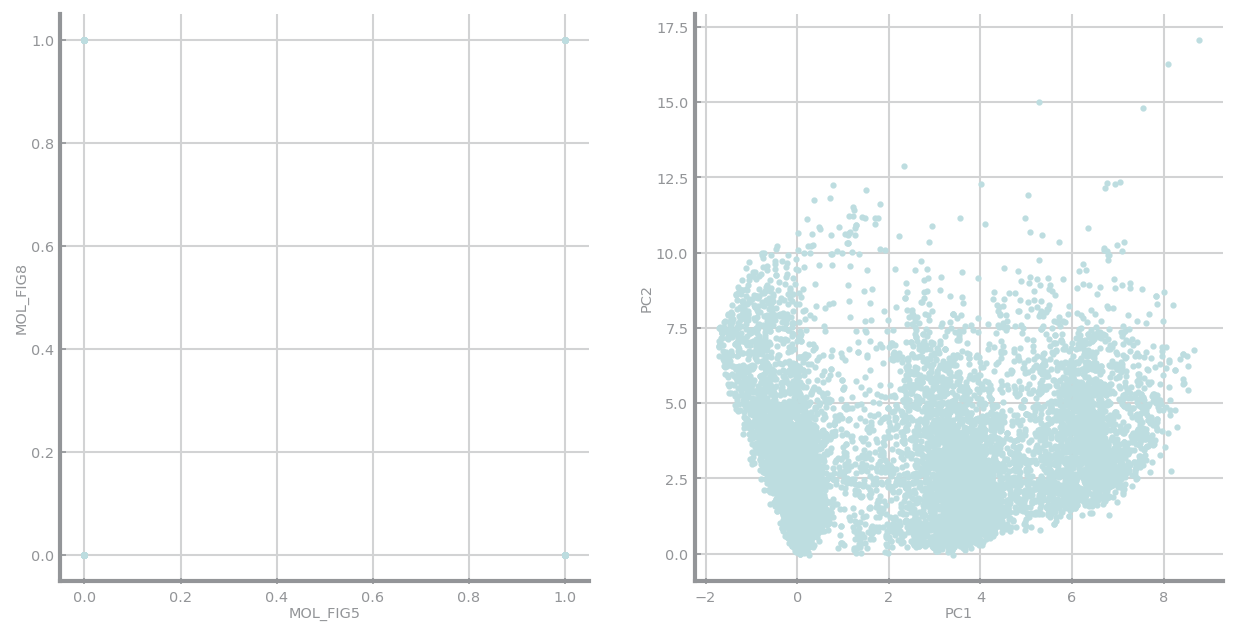

In [7]:
transf = pca.transform(data)

_, axs = plt.subplots(1, 2, figsize=(2*5, 1*5), squeeze=False)
axs[0,0].set_xlabel(variables[eixo_y])
axs[0,0].set_ylabel(variables[eixo_z])
axs[0,0].scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])

axs[0,1].set_xlabel('PC1')
axs[0,1].set_ylabel('PC2')
axs[0,1].scatter(transf[:, 0], transf[:, 1])
plt.show()

PC- Eixos principais no Feature Space representando as direcções de variância máxima nos dados

## Clustering comparison after PCA

### K-Means

In [25]:
data = pd.DataFrame(transf[:,:2], columns=['PC1', 'PC2'])
eixo_x = 0
eixo_y = 1

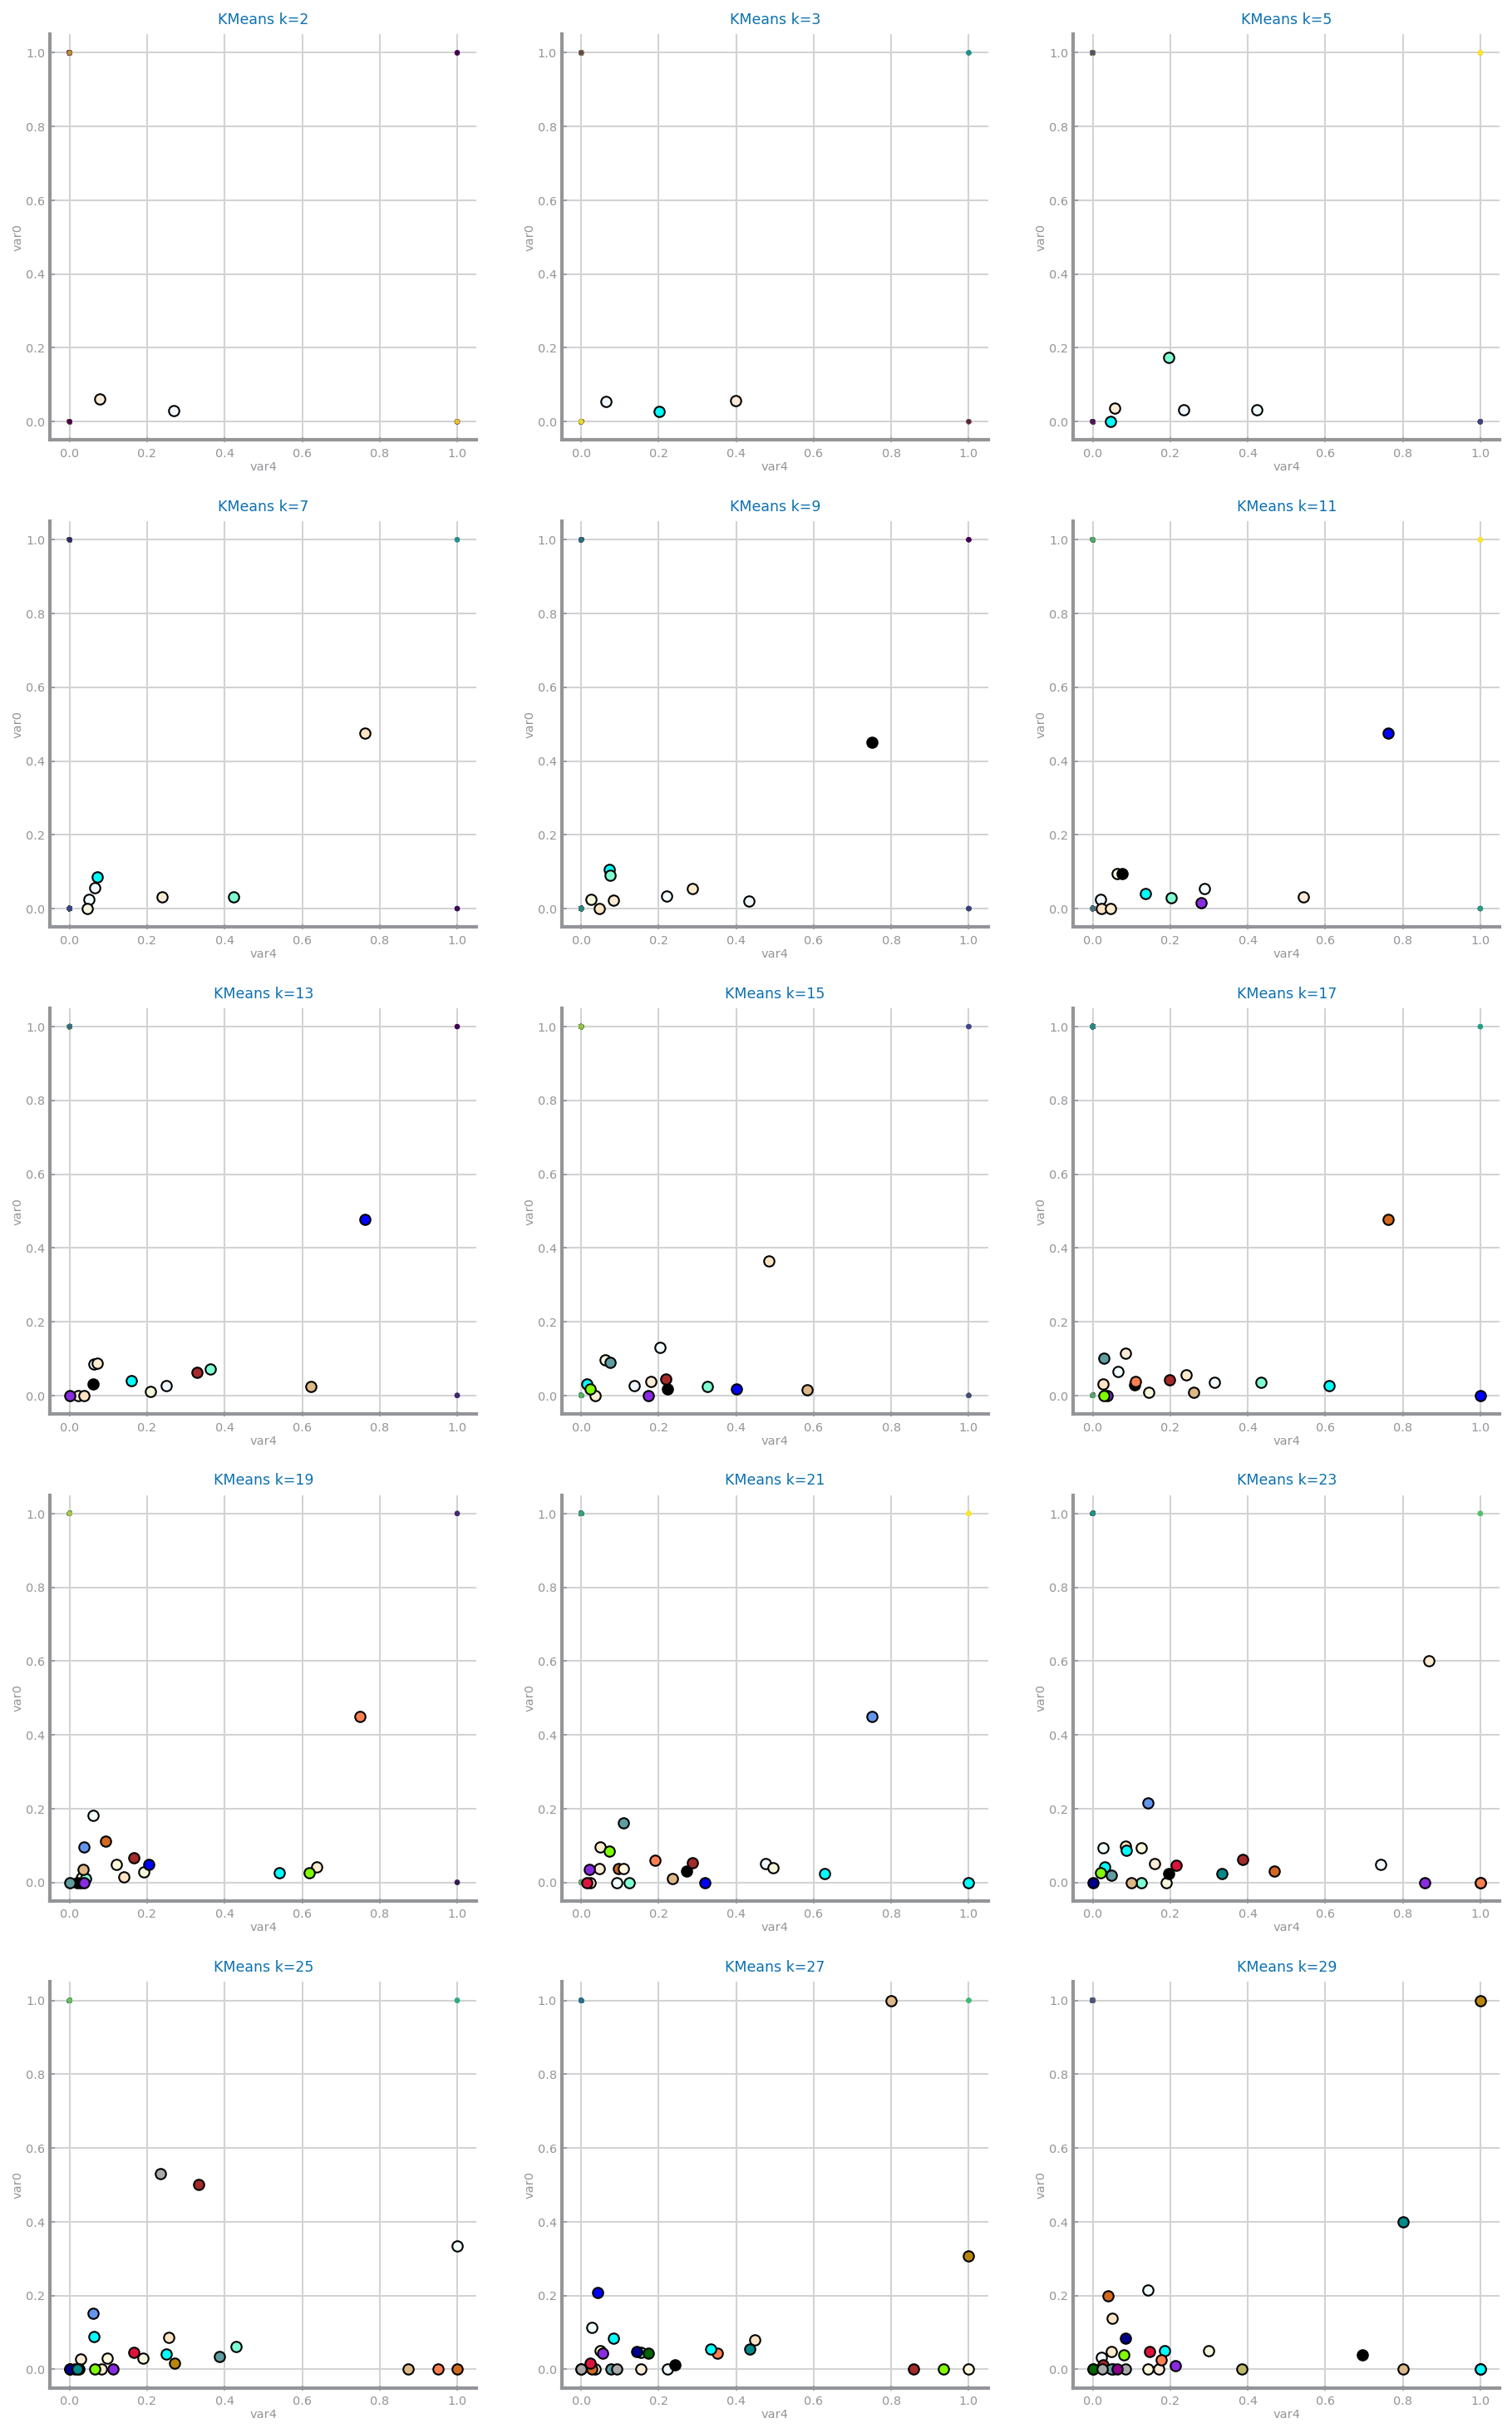

In [18]:
N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, eixo_x, eixo_y, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

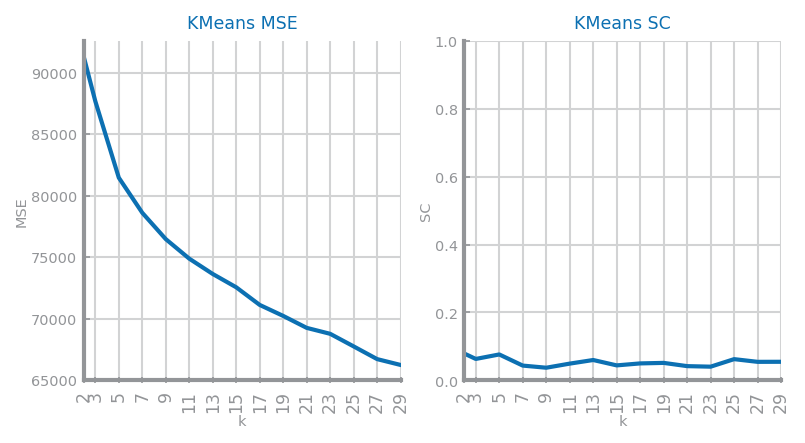

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

### Density-based

*EPS - Studying the Maximum Distance Impact*

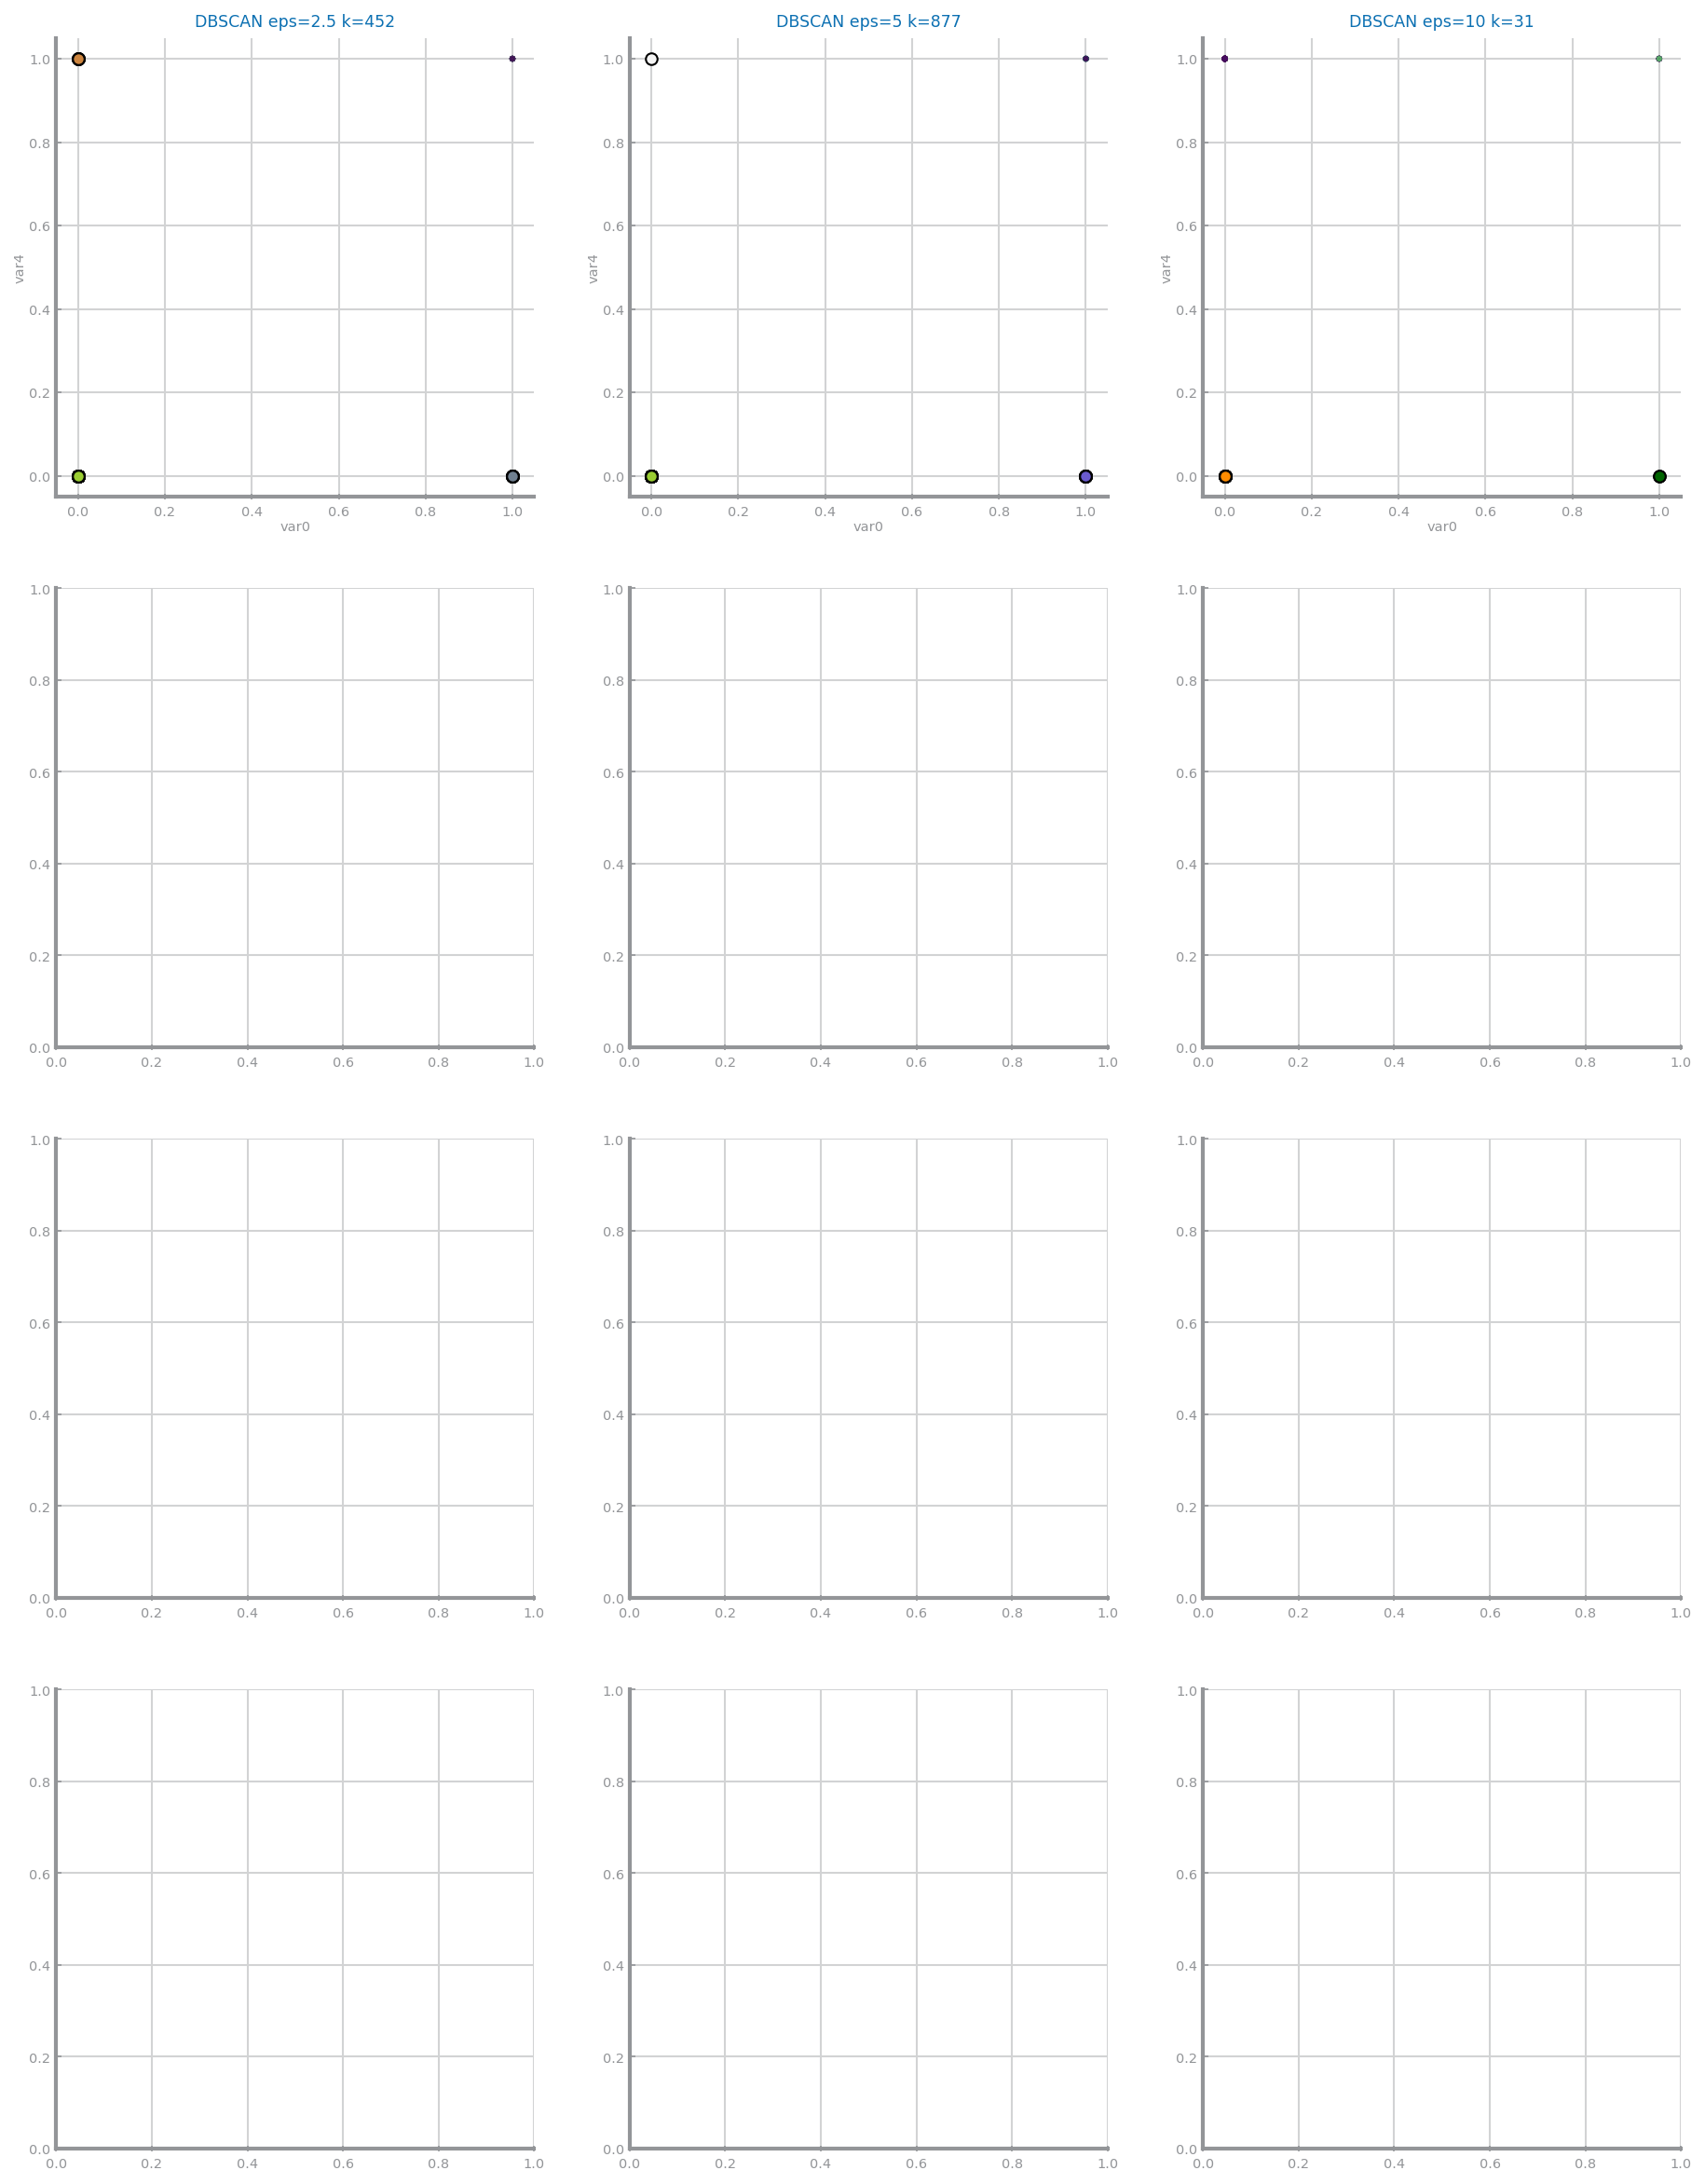

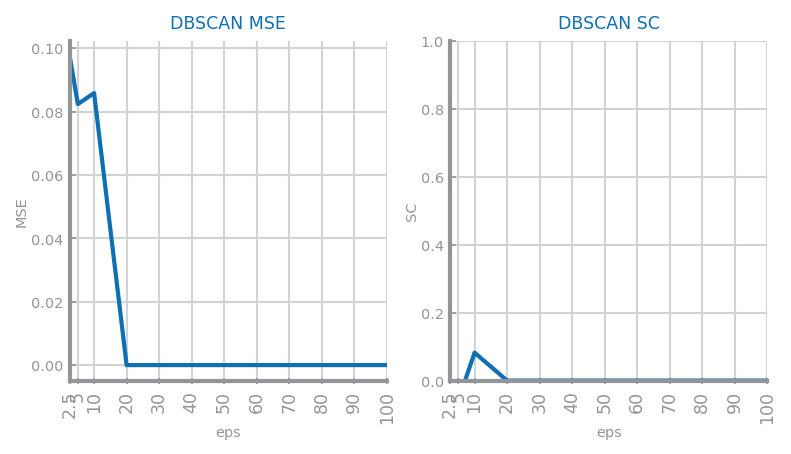

In [12]:
clustering_density_eps(data, eixo_x, eixo_y)

*Metric*

AVG distances among records [11.441172559146954, 134.88438321707076, 0.9998726131412976, 0.7082288366972024, 0.8318665315949874]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]




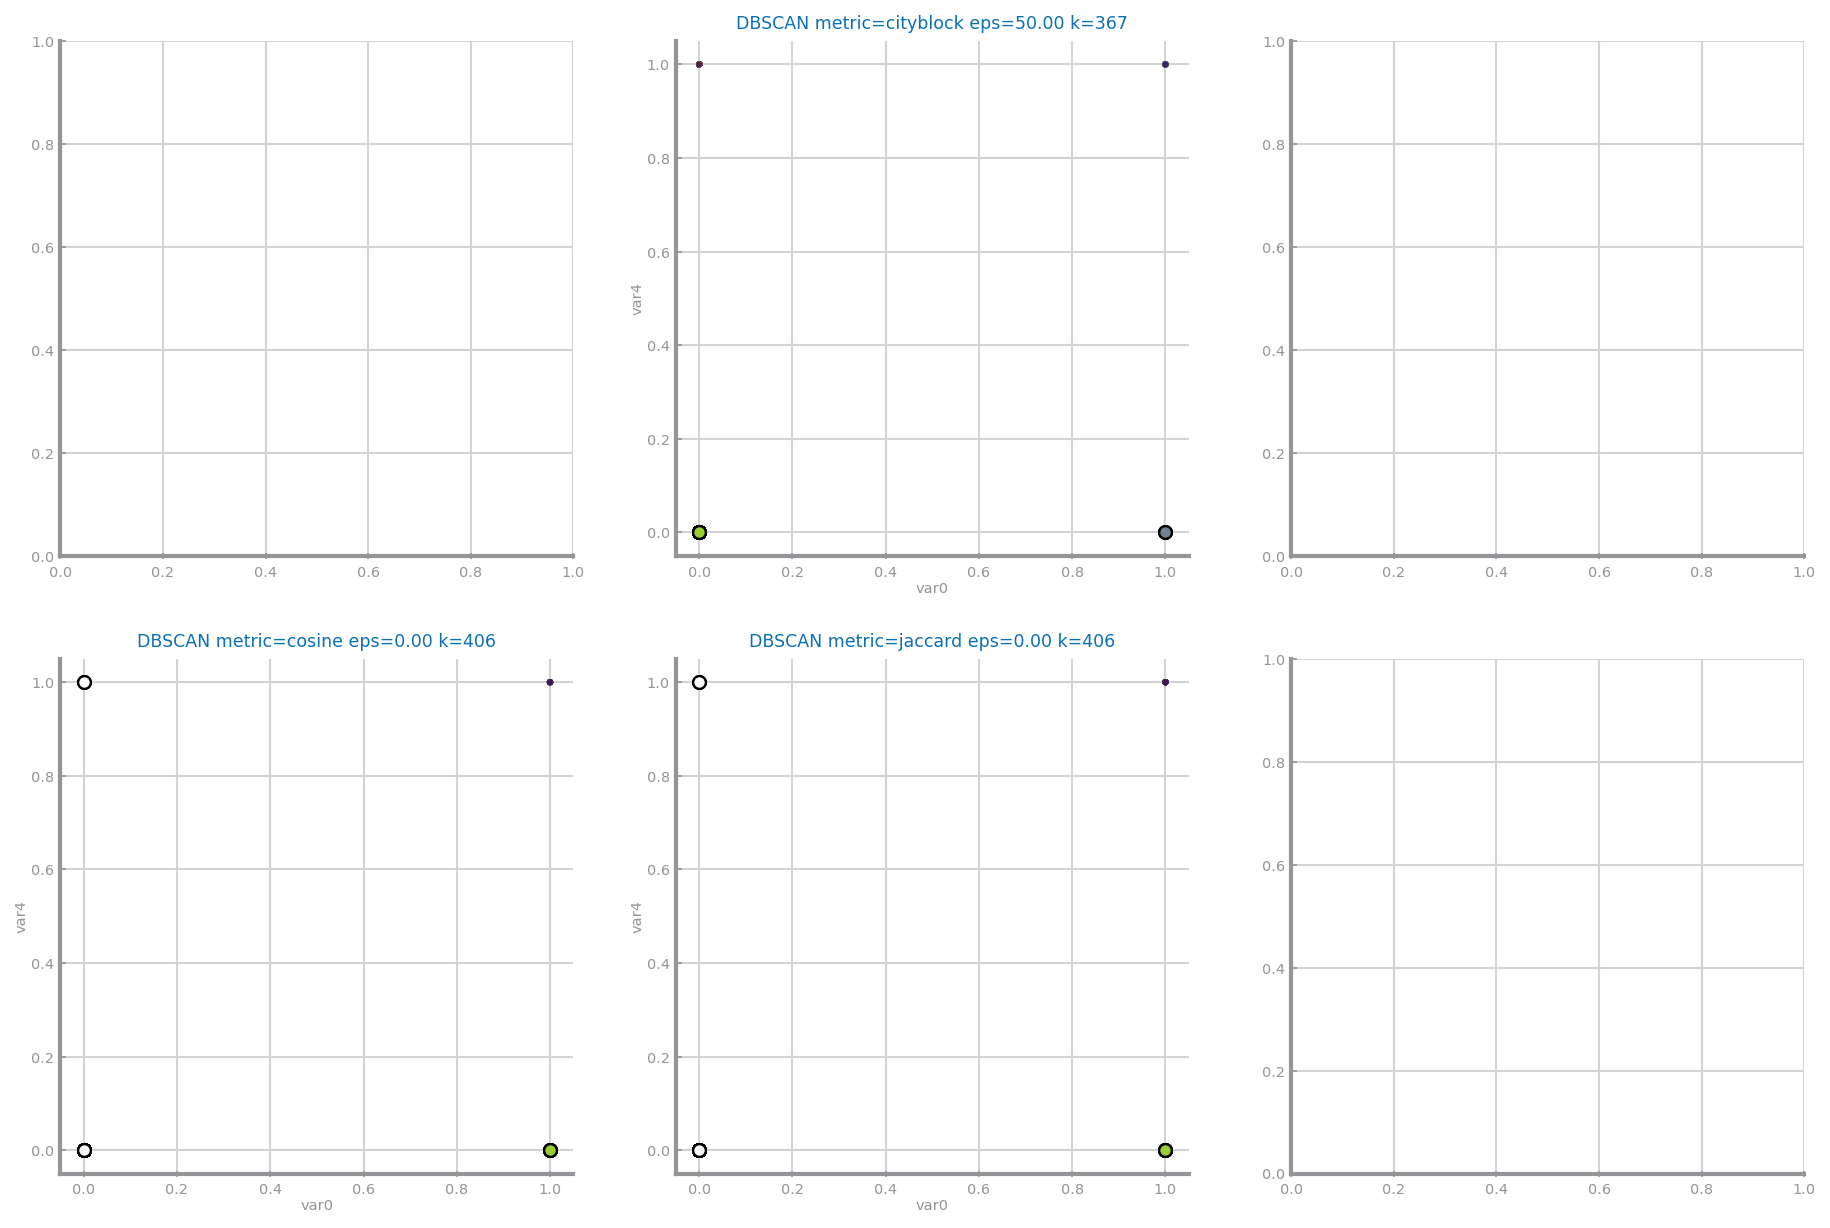

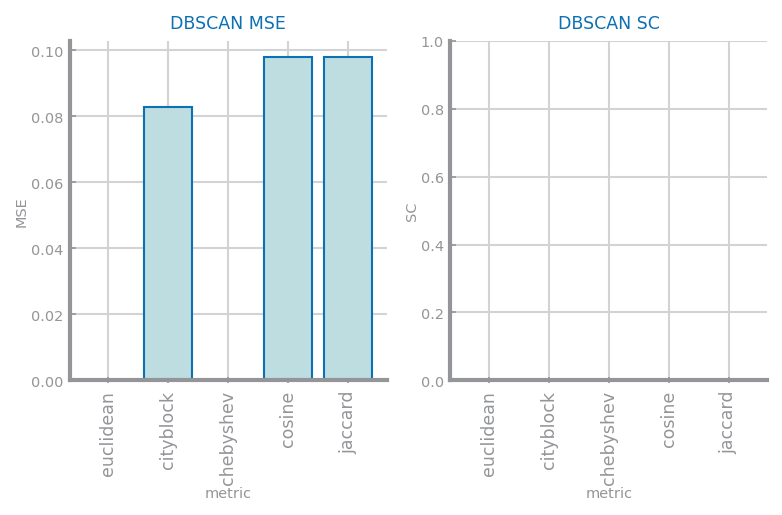

In [13]:
clustering_density_metric(data, eixo_x, eixo_y)

Resultados semelhantes

### Hierarchical

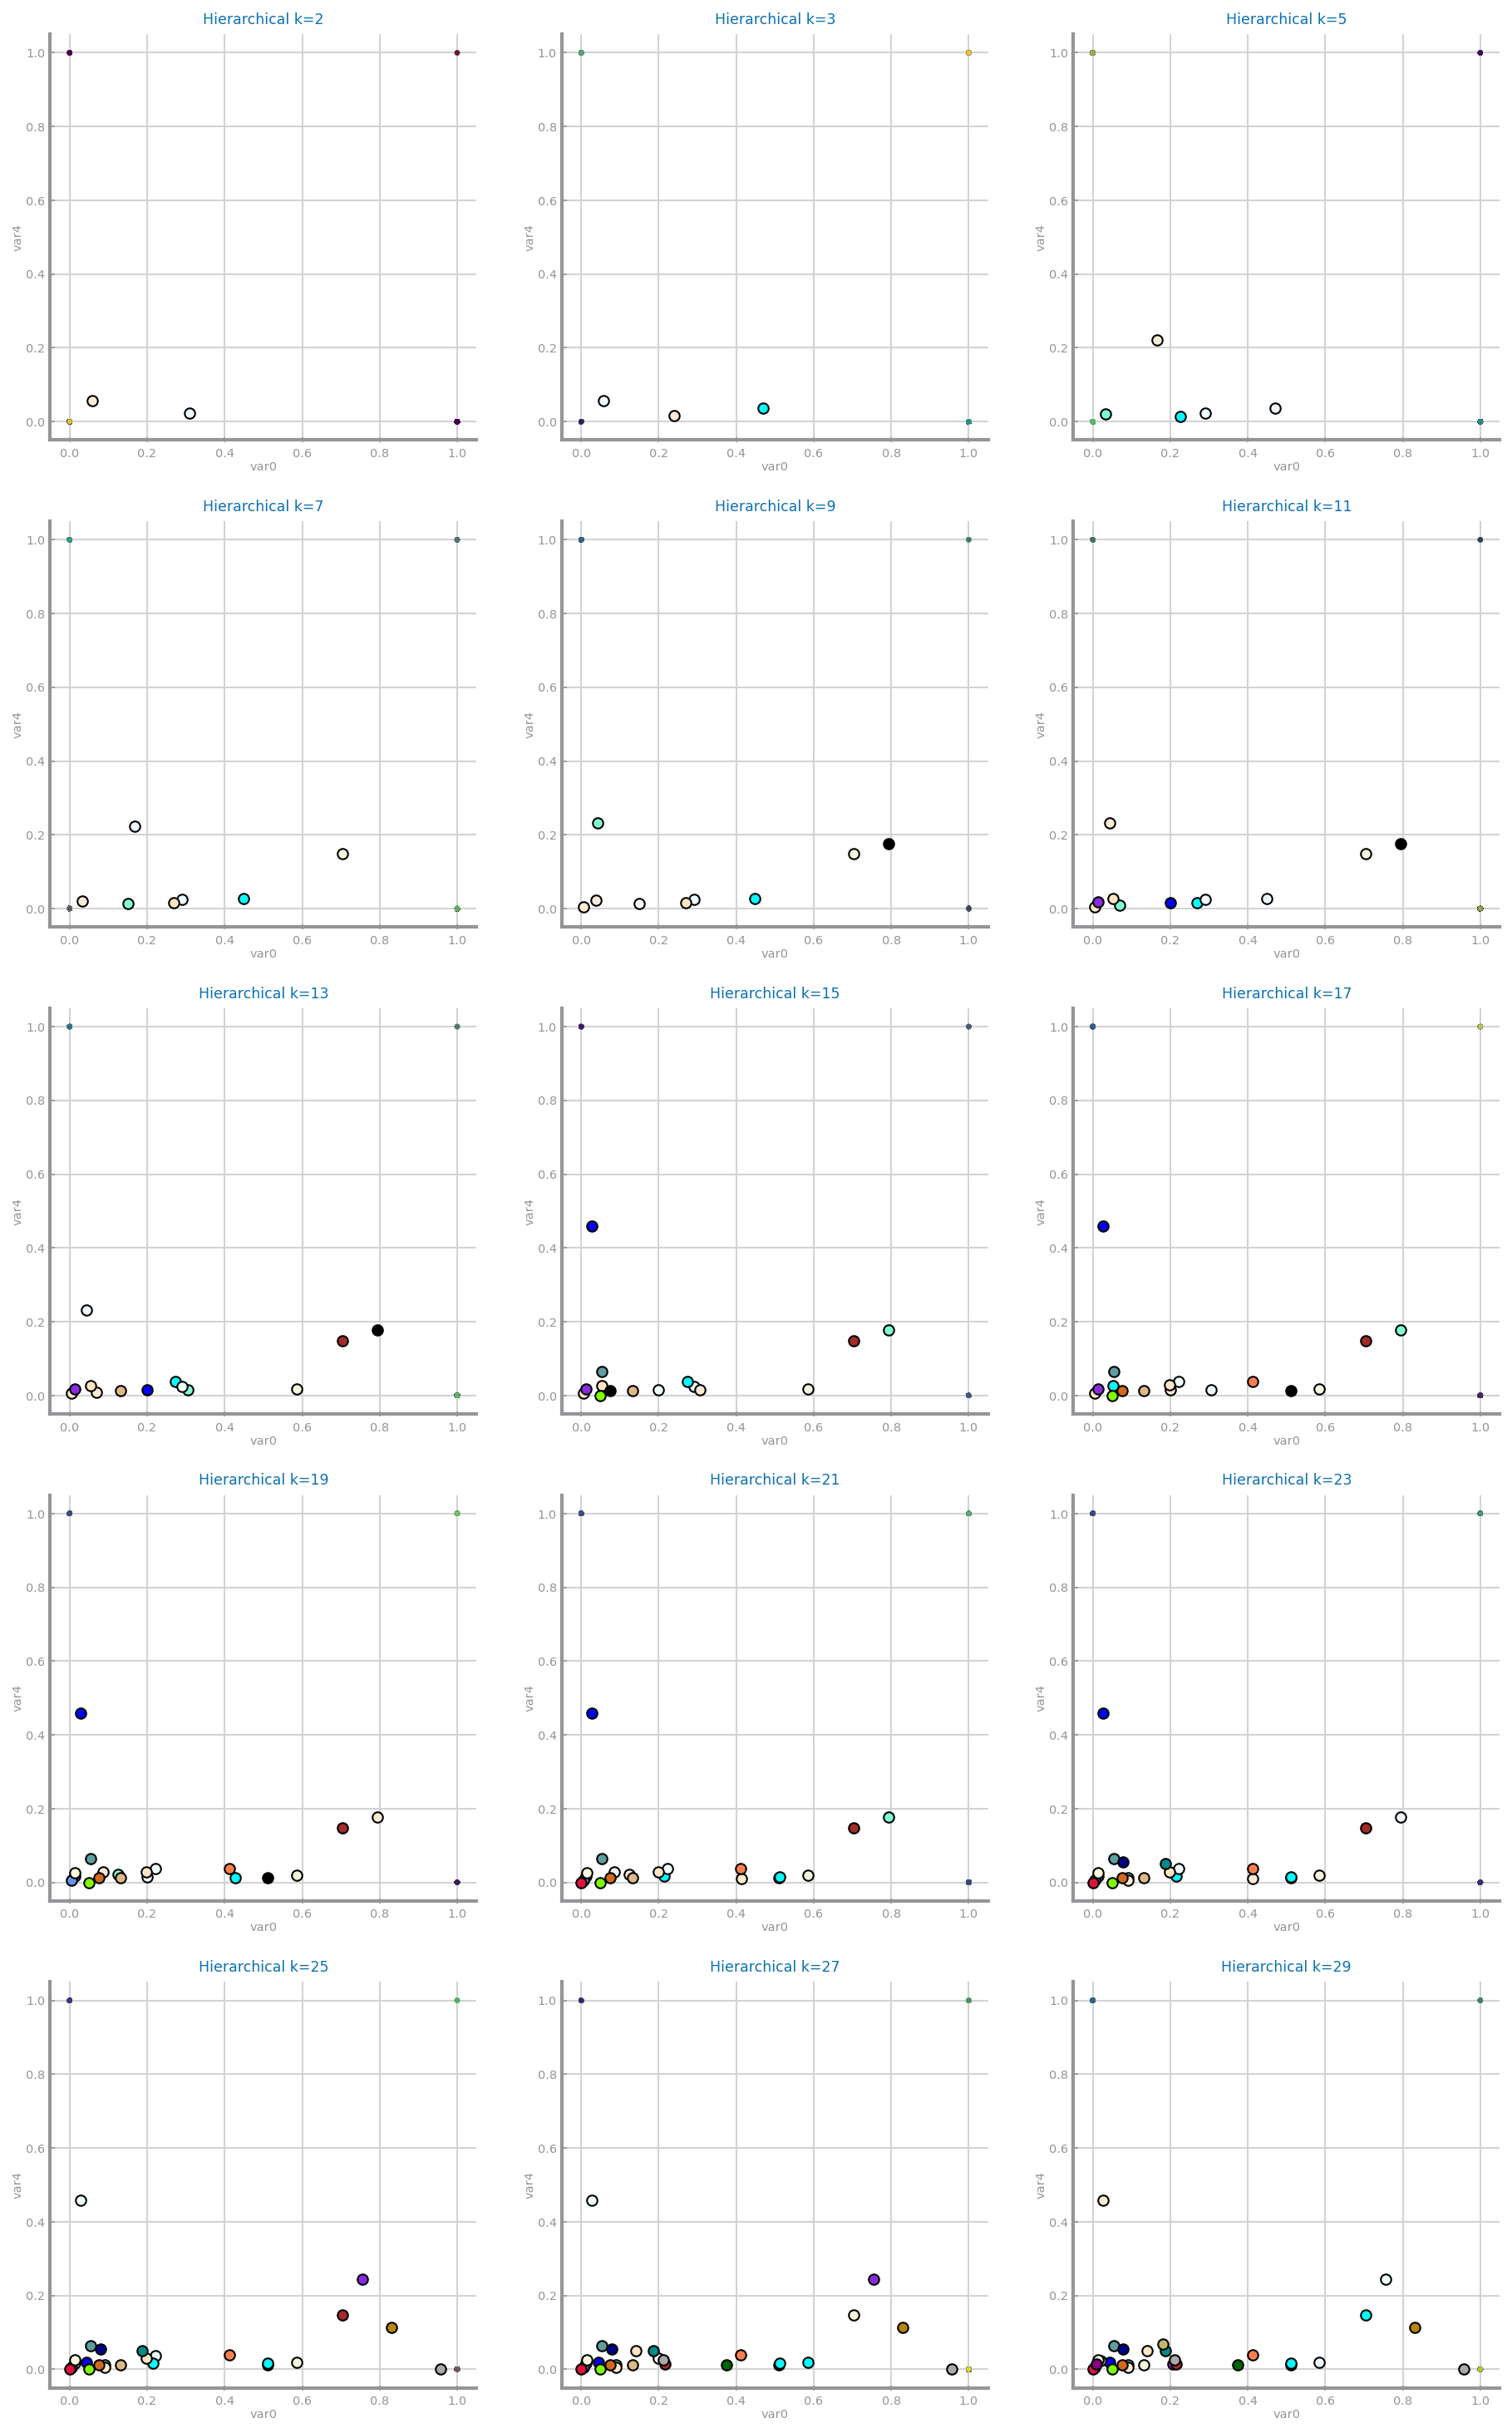

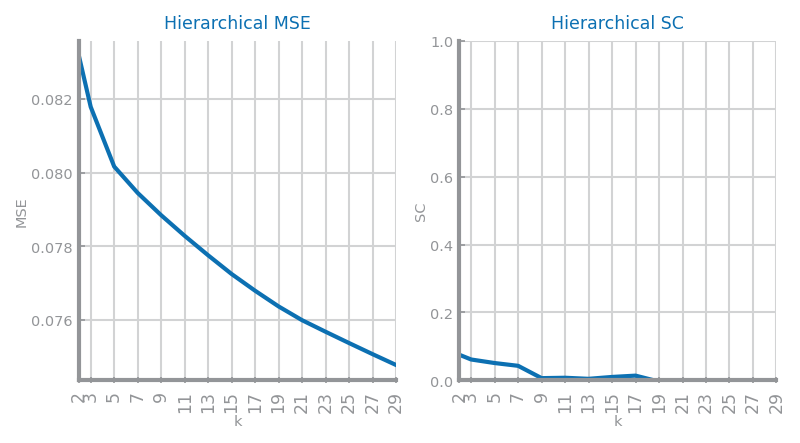

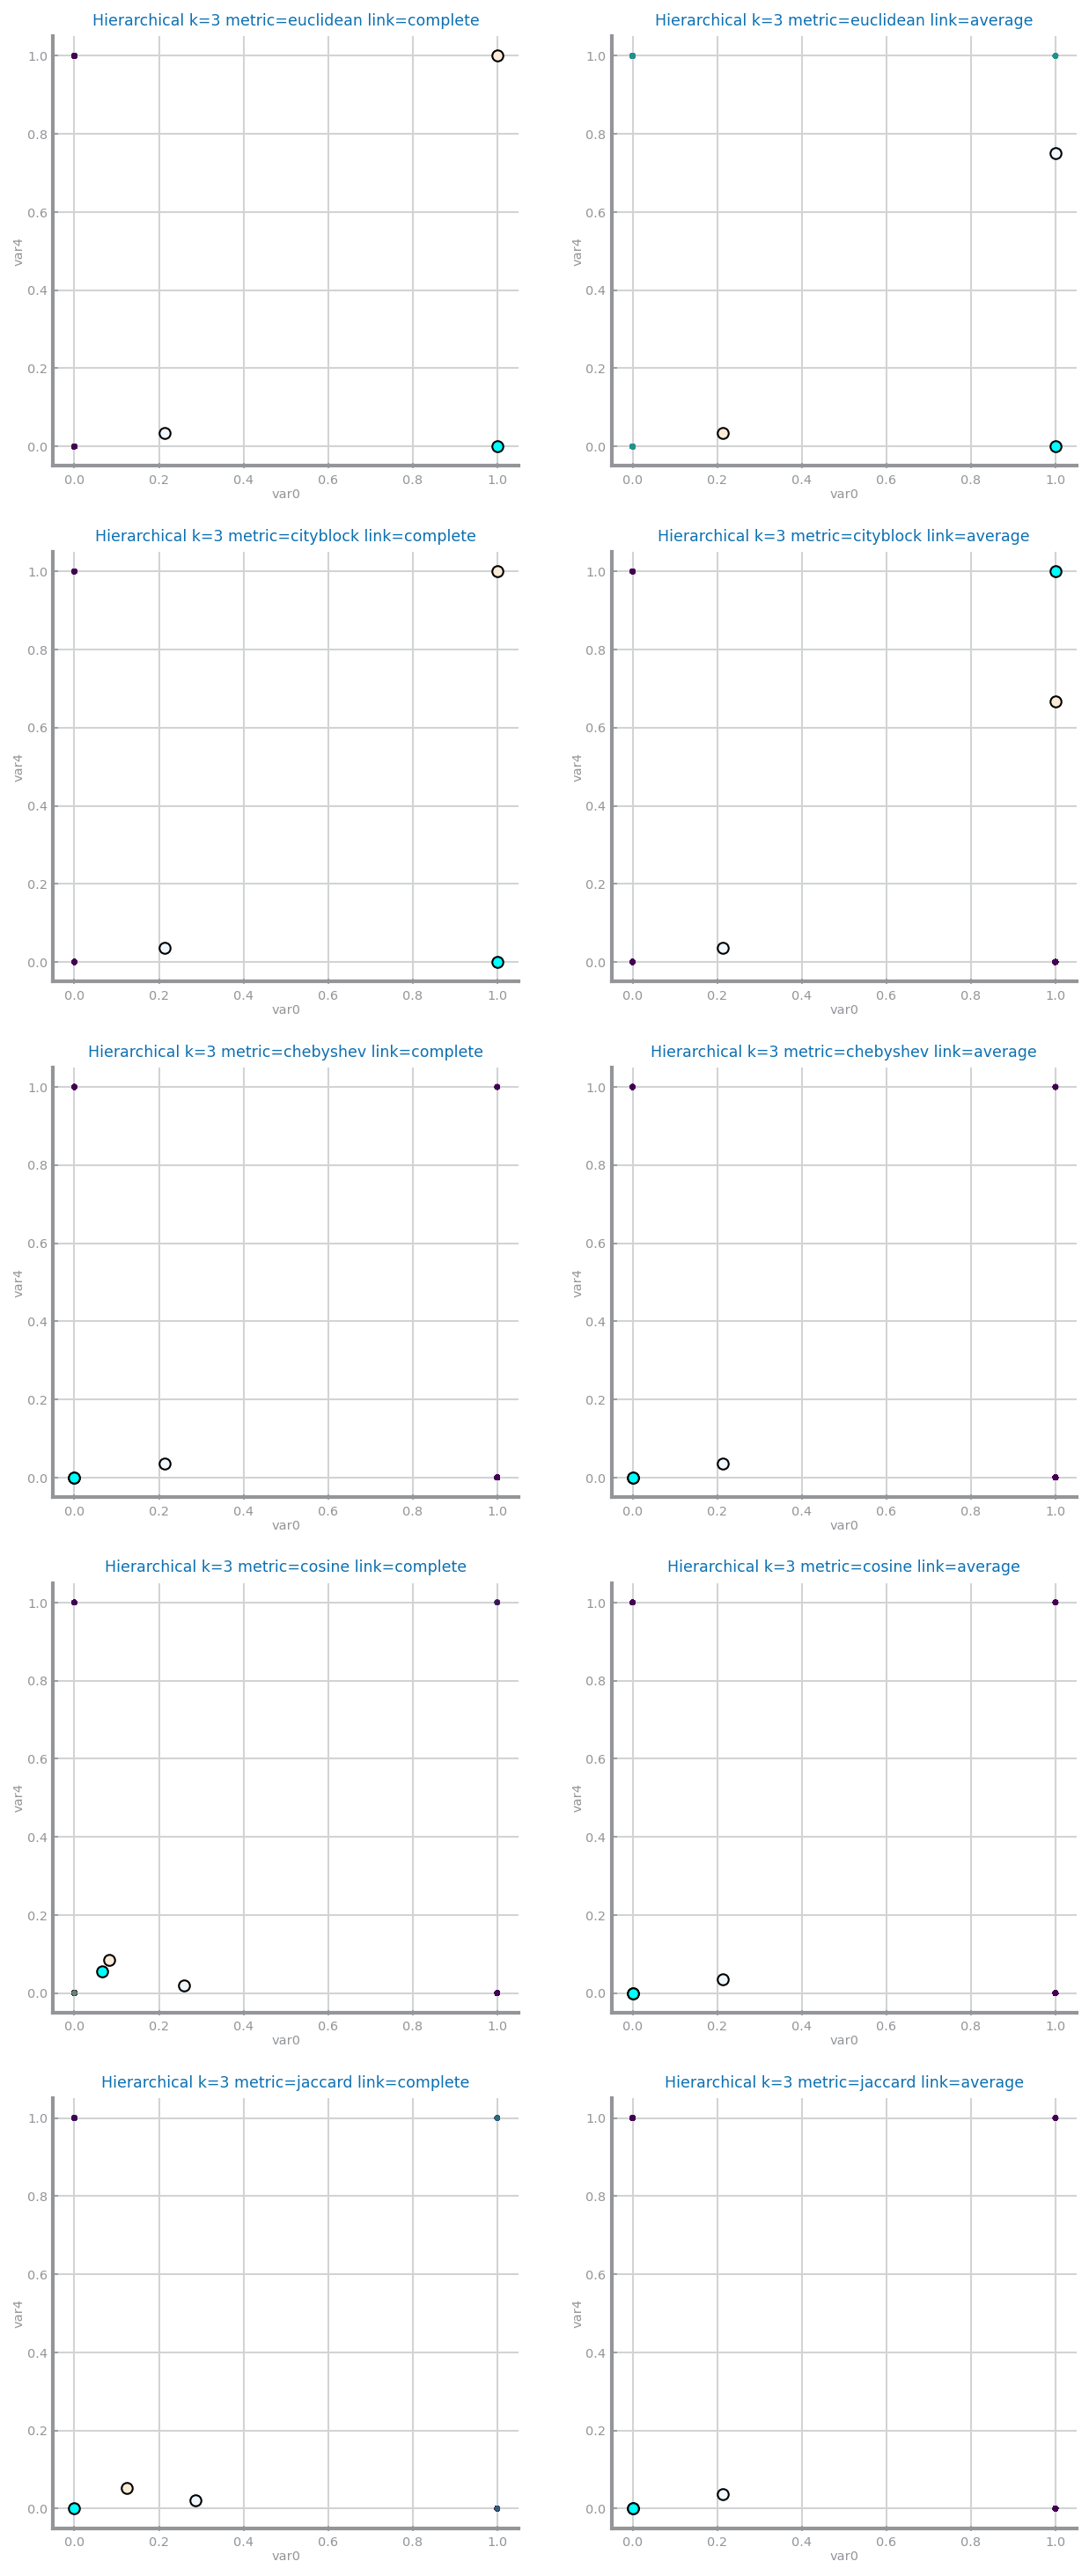

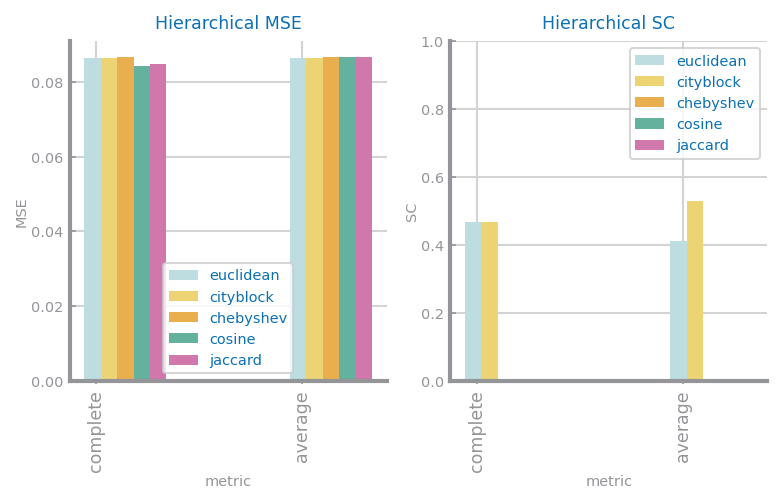

In [14]:
clustering_hierarchical(data, eixo_x, eixo_y)

Resultados semelhantes